# Detection of chaotic and deterministic signals on the basis of the LSTM model training results

Detection of chaos in dynamical signals is an important and popular research area. Traditionally, the chaotic behavior is evaluated by calculating the Maximal Lyapunov Exponent (MLE). However, calculating the MLE is sometimes difficult and requires specific data. Moreover, it introduces some subjective assumptions and is sometimes called a “manual” method. Therefore, there are many attempts to provide alternative ways to assess the dynamical signal as chaotic or deterministic. Some of them use deep learning methods.  

In this paper, we present a novel method of signal classification that is based on the assumption that it is easier to learn deterministic behavior than a chaotic one. We show that based on this assumption, it is possible to calculate the “amount of chaos” in the signal with the help of a simple LSTM neural network. The main advantage of this method is that – contrary to other deep learning-based methods - it does not require prior data to train the network, as the results of the training process for a signal being classified are taken into account as the result of this evaluation.

We confirm the method's validity using the publicly available dataset of chaotic and deterministic signals.

In [1]:
import tensorflow as tf
import numpy as np
import os
import time
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import RNN, LSTM, GRU, Dense
import pandas as pd
from matplotlib import pyplot as plt
from statistics import median
from scipy.stats import ttest_ind,mannwhitneyu
import json
import math
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score,cohen_kappa_score

os.environ['CUDA_VISIBLE_DEVICES'] = '0'
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

if tf.test.gpu_device_name():
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))
else:
    print("Please install GPU version of TF")

Default GPU Device: /device:GPU:0


# Methods

## 3.1 The simple LSTM Model
The model gest a sequence of 10 values and tries to predict the next (11th) value of the signal

In [ ]:
def build_model(units=64):
    model = tf.keras.Sequential()
    model.add(LSTM(units, input_shape=(10,1)))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    return model
model = build_model()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 64)                16896     
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
Total params: 16,961
Trainable params: 16,961
Non-trainable params: 0
_________________________________________________________________


2024-02-16 12:21:23.990173: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-02-16 12:21:23.990312: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-02-16 12:21:23.990620: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-02-16 12:21:23.991472: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-02-16 12:21:23.991801: I tensorflow/compiler/xla/stream_executo

In [ ]:
#!pip install keras_utils
#!pip install pydot
#!pip install graphviz

## 3.2 Dataset
The dataset consists of signals created by 10 different generators obtained from the XXX dataset. Signals of each type are stored in separate directories and each directory consists of 10 files with signals containing 1000 values.
Types with names starting with 'C0' represent chaotic signals, types statring with 'C1' represent deterministic ones. There are five chaotic and five deterministic signal types.

### Load and unzip the dataset

In [2]:
!wget www.kasprowski.pl/datasets/chaos_dataset.zip
!unzip chaos_dataset.zip

--2024-02-16 13:37:23--  http://www.kasprowski.pl/datasets/chaos_dataset.zip
Resolving www.kasprowski.pl (www.kasprowski.pl)... 94.152.164.213
Connecting to www.kasprowski.pl (www.kasprowski.pl)|94.152.164.213|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2156725 (2.1M) [application/zip]
Saving to: ‘chaos_dataset.zip’

chaos_dataset.zip   100%[===================>]   2.06M  1.33MB/s    in 1.5s    

2024-02-16 13:37:25 (1.33 MB/s) - ‘chaos_dataset.zip’ saved [2156725/2156725]

Archive:  chaos_dataset.zip
  inflating: C0ModelHalvorsenA513/C0ModelHalvorsenA513-1.txt  
  inflating: C0ModelHalvorsenA513/C0ModelHalvorsenA513-10.txt  
  inflating: C0ModelHalvorsenA513/C0ModelHalvorsenA513-2.txt  
  inflating: C0ModelHalvorsenA513/C0ModelHalvorsenA513-3.txt  
  inflating: C0ModelHalvorsenA513/C0ModelHalvorsenA513-4.txt  
  inflating: C0ModelHalvorsenA513/C0ModelHalvorsenA513-5.txt  
  inflating: C0ModelHalvorsenA513/C0ModelHalvorsenA513-6.txt  
  inflating: C0ModelHa

In [3]:
files = ['C0ModelHalvorsenA513',
'C0ModelLorenzA51',
'C0ModelRoslerA52',
'C0ModelRucklideA515',
'C0ModelUedaA45',
'C1LinearOscBooming01',
'C1LinearOscFading01',
'C1LinearOscFading02',
'C1LinearOscillator01',
'C1LinearOscillator02']

## 3.3 Loading data
Each file contains 1000 values. The method opens the given file and divides it to chunks of $size$. We used $size=10$ in this experiment.
Parameters:
- $file$, $num$ - identification of the file
- $size$ - length of a sequence to train
- $stride$ - the shift for the next sequence, if shift==size, sequences do not overlap
- $skip$ - if skip>1 some values are skipped - for instance for skip=2 every value with even index is skipped (used to artificially increase signal's variablitity)

In [4]:
def read_data(file,num=1,size=10,stride=10,skip=1):
    df = pd.read_csv(f'{file}/{file}-{num}.txt',header=None,usecols=[0])
    data = df.to_numpy()
    data = data[::skip]
    N = len(data)
    train_samples = []
    train_labels = []
    for i in range(0,N-size,stride):
        train_samples.append(data[i:i+size])
        train_labels.append(data[i+size])
    train_samples = np.array(train_samples)
    train_labels = np.array(train_labels)
    return train_samples,train_labels

# Checking H1:
# Loss values calculated for subsequent epochs while the model is trained with the deterministic signals are lower than for chaotic signals

## 4.1: Training models for each signal in 200 epochs

In [ ]:
# The number of epochs
EPOCHS=200

Train model with the given number of units, show results (loss values) and calculate statistical significance of differences between medians of losses for chaotic (C0) and deterministic (C1) signals

Algorithm:

For all 100 data files (10 types and 10 signals for each):
- divide into chunks of 10 signals + 11th signal as label
- fit the model for 200 epochs and register losses
- save losses as a vector of 200 values


In [ ]:
def train_model(units=64):
  median_losses = {}
  median_losses["c0"] = []
  median_losses["c1"] = []


  for f in files:
      print(f,end=' ')
      for i in range(1,11):
          model = build_model(units)
          train_samples,train_labels = read_data(f,i)
          H = model.fit(train_samples,train_labels,epochs=EPOCHS,verbose=0,batch_size=64)
          epochs = range(1, len(H.history['loss']) + 1)
          if f.startswith('C0'):
              col='red'
              median_losses["c0"].append(median(H.history['loss']))
          if f.startswith('C1'):
              col='blue'
              median_losses["c1"].append(median(H.history['loss']))
          if i==0:
            plabel = f
          else:
            plabel = '_nolegend_'
          plt.plot(epochs, H.history['loss'], label=plabel,color=col)
          #print(f"{f}-{i} - median loss {median(H.history['loss']):.4f}, final loss {H.history['loss'][-1]:.4f}")
          print('.',end='')
      print()
  plt.xlabel("Epoch")
  plt.ylabel("Loss (MSE)")
  #plt.legend(loc="upper right")
  mwg = mannwhitneyu(median_losses["c0"],median_losses["c1"],alternative='greater')
  print('mann-whitney greater test=',mwg)

  plt.title(f"Units: {units}, U={mwg.statistic}, p={mwg.pvalue:.3f}")
  plt.show()


  with open(f"median_losses_{units}.json", "w") as outfile:
      json.dump(median_losses, outfile)



===== UNITS 1
C0ModelHalvorsenA513 ..........
C0ModelLorenzA51 ..........
C0ModelRoslerA52 ..........
C0ModelRucklideA515 ..........
C0ModelUedaA45 ..........
C1LinearOscBooming01 ..........
C1LinearOscFading01 ..........
C1LinearOscFading02 ..........
C1LinearOscillator01 ..........
C1LinearOscillator02 .........

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


.
mann-whitney greater test= MannwhitneyuResult(statistic=2311.0, pvalue=1.3268345598468616e-13)


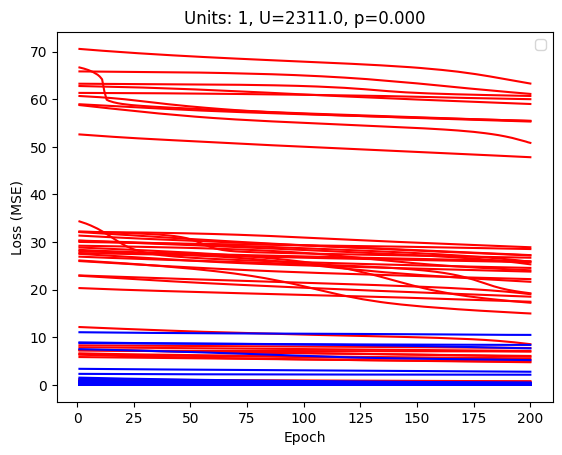

===== UNITS 8
C0ModelHalvorsenA513 ..........
C0ModelLorenzA51 ..........
C0ModelRoslerA52 ..........
C0ModelRucklideA515 ..........
C0ModelUedaA45 ..........
C1LinearOscBooming01 ..........
C1LinearOscFading01 ..........
C1LinearOscFading02 ..........
C1LinearOscillator01 ..........
C1LinearOscillator02 .........

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


.
mann-whitney greater test= MannwhitneyuResult(statistic=2346.0, pvalue=2.1401671137610696e-14)


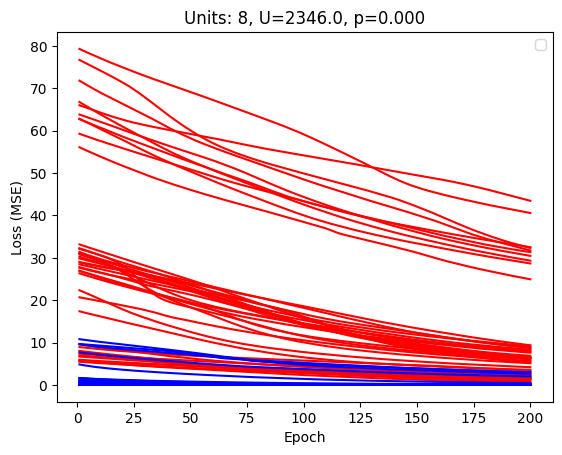

===== UNITS 32
C0ModelHalvorsenA513 ..........
C0ModelLorenzA51 ..........
C0ModelRoslerA52 ..........
C0ModelRucklideA515 ..........
C0ModelUedaA45 ..........
C1LinearOscBooming01 ..........
C1LinearOscFading01 ..........
C1LinearOscFading02 ..........
C1LinearOscillator01 ..........
C1LinearOscillator02 .........

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


.
mann-whitney greater test= MannwhitneyuResult(statistic=2426.0, pvalue=2.665946654617255e-16)


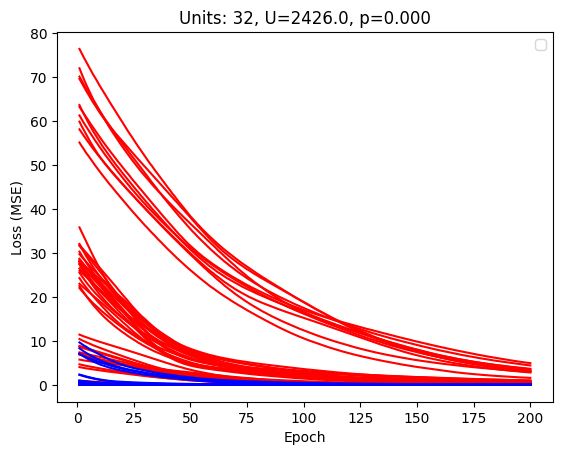

===== UNITS 64
C0ModelHalvorsenA513 ..........
C0ModelLorenzA51 ..........
C0ModelRoslerA52 ..........
C0ModelRucklideA515 ..........
C0ModelUedaA45 ..........
C1LinearOscBooming01 ..........
C1LinearOscFading01 ..........
C1LinearOscFading02 ..........
C1LinearOscillator01 ..........
C1LinearOscillator02 .........

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


.
mann-whitney greater test= MannwhitneyuResult(statistic=2456.0, pvalue=4.7649888817850484e-17)


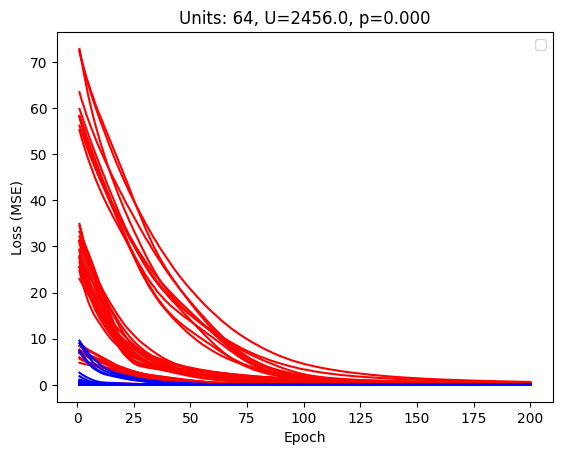

===== UNITS 128
C0ModelHalvorsenA513 ..........
C0ModelLorenzA51 ..........
C0ModelRoslerA52 ..........
C0ModelRucklideA515 ..........
C0ModelUedaA45 ..........
C1LinearOscBooming01 ..........
C1LinearOscFading01 ..........
C1LinearOscFading02 ..........
C1LinearOscillator01 ..........
C1LinearOscillator02 .........

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


.
mann-whitney greater test= MannwhitneyuResult(statistic=2484.0, pvalue=9.19580139925871e-18)


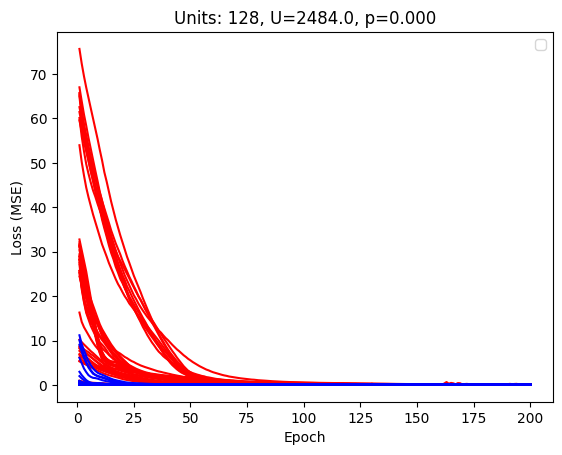

===== UNITS 256
C0ModelHalvorsenA513 ..........
C0ModelLorenzA51 ..........
C0ModelRoslerA52 ..........
C0ModelRucklideA515 ..........
C0ModelUedaA45 ..........
C1LinearOscBooming01 ..........
C1LinearOscFading01 ..........
C1LinearOscFading02 ..........
C1LinearOscillator01 ..........
C1LinearOscillator02 .........

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


.
mann-whitney greater test= MannwhitneyuResult(statistic=2493.0, pvalue=5.37706962437211e-18)


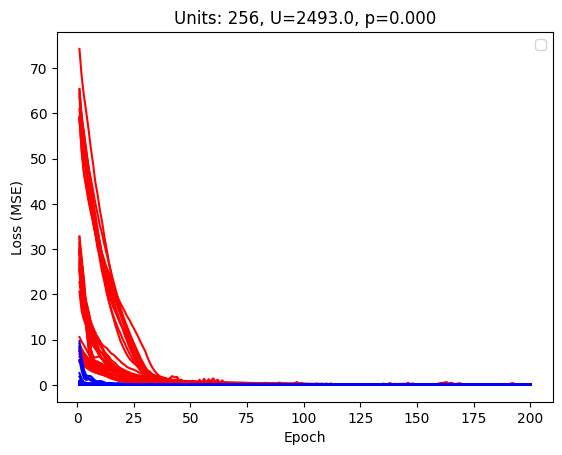

In [ ]:
for u in (1,8,32,64,128,256):
  print(f"===== UNITS {u}")
  train_model(u)

In [ ]:
# restore from file
import json

for u in (1,8,32,64,128,256):
  print(f"===== UNITS {u}")
  with open(f"median_losses_{u}.json", 'r') as infile:
    data = json.load(infile)
  median_losses = data
  mwg = mannwhitneyu(median_losses['c0'],median_losses['c1'],alternative='greater')
  print('mann-whitney greater test=',mwg)

===== UNITS 1
mann-whitney greater test= MannwhitneyuResult(statistic=2311.0, pvalue=1.3268345598468616e-13)
===== UNITS 8
mann-whitney greater test= MannwhitneyuResult(statistic=2346.0, pvalue=2.1401671137610696e-14)
===== UNITS 32
mann-whitney greater test= MannwhitneyuResult(statistic=2426.0, pvalue=2.665946654617255e-16)
===== UNITS 64
mann-whitney greater test= MannwhitneyuResult(statistic=2456.0, pvalue=4.7649888817850484e-17)
===== UNITS 128
mann-whitney greater test= MannwhitneyuResult(statistic=2484.0, pvalue=9.19580139925871e-18)
===== UNITS 256
mann-whitney greater test= MannwhitneyuResult(statistic=2493.0, pvalue=5.37706962437211e-18)


<span style="color:blue">Comment: it is visible that for nonchaotic signals (blue) losses (mean squared errors) are lower than for chaotic signals (red) and Mann Whitney U Test shows that the difference is significant</span>.

## 4.1.1 Checking PyTorch implementation with 64 units


C0ModelHalvorsenA513 ..........
C0ModelLorenzA51 ..........
C0ModelRoslerA52 ..........
C0ModelRucklideA515 ..........
C0ModelUedaA45 ..........
C1LinearOscBooming01 ..........
C1LinearOscFading01 ..........
C1LinearOscFading02 ..........
C1LinearOscillator01 ..........
C1LinearOscillator02 ..........
mann-whitney greater test= MannwhitneyuResult(statistic=2394.0, pvalue=1.5970034194921397e-15)


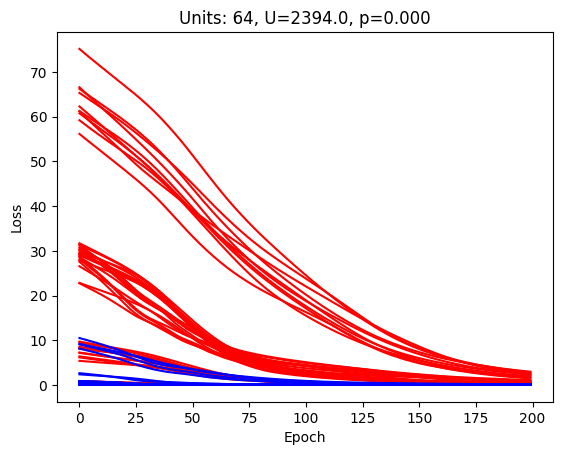

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from statistics import median
from scipy.stats import ttest_ind,mannwhitneyu

# Define the LSTM model
class MyLSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(MyLSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        lstm_out, _ = self.lstm(x.permute(1,0,2))
        output = self.fc(lstm_out[-1])  # Only take the last time step
        return output

# Create an instance of the model
input_size = 1  # Input size (number of features in each time step)
hidden_size = 64  # Hidden size of the LSTM layer
output_size = 1  # Output size


median_losses_c0 = []
median_losses_c1 = []
for f in files:
    print()
    print(f,end=' ')
    for i in range(1,11):
        train_samples,train_labels = read_data(f,i)
        model = MyLSTMModel(input_size, hidden_size, output_size)

        # Define loss function and optimizer
        criterion = nn.MSELoss()
        optimizer = optim.Adam(model.parameters(), lr=0.001)

        # Training data
        sequences = torch.from_numpy(train_samples).float()
        #sequences = torch.tensor(sequences, requires_grad=True)
        sequences = sequences.clone().detach().requires_grad_(True)

        targets = torch.from_numpy(train_labels).float()
        #targets = torch.tensor(targets, requires_grad=True)
        targets = targets.clone().detach().requires_grad_(True)

        # Training loop
        loss_history = []  # List to store the history of losses

        for epoch in range(200):  # Replace 1000 with the desired number of epochs
            optimizer.zero_grad()
            output = model(sequences)
            loss = criterion(output, targets)  # Adjust target shape
            loss.backward()
            optimizer.step()

            loss_history.append(loss.item())  # Store the current loss
        if f.startswith('C0'):
            col='red'
            median_losses_c0.append(median(loss_history))
        if f.startswith('C1'):
            col='blue'
            median_losses_c1.append(median(loss_history))
        plt.plot(loss_history, label=f"{f}",color=col)
        print('.',end='')

print()
mwg = mannwhitneyu(median_losses_c0,median_losses_c1,alternative='greater')
print('mann-whitney greater test=',mwg)

plt.title(f"Units: {hidden_size}, U={mwg.statistic}, p={mwg.pvalue:.3f}")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()


## 4.1.2 Checking ranges of signal values
Next, we check what ranges of values have signals

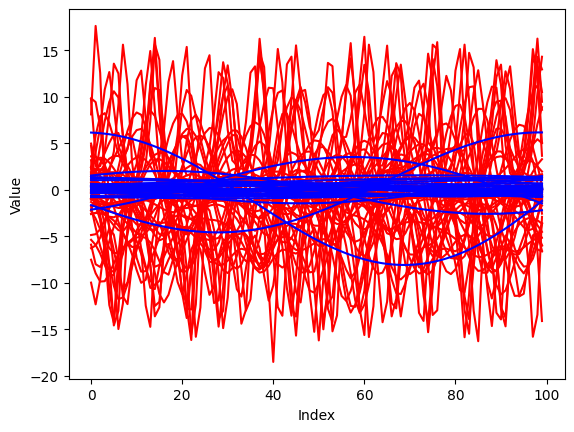

In [ ]:
for f in files:
    train_samples,train_labels = read_data(f,1,100,100)
    for i in range(len(train_samples)):
            if f.startswith('C0'): color='red'
            if f.startswith('C1'): color='blue'
            plt.plot(train_samples[i,:],label=f"{f}",color=color)
    #plt.title(f)
    #plt.show()

plt.xlabel("Index")
plt.ylabel("Value")
plt.show()

Because it occured that chaotic signals have higher ranges than nonchaotic, we decided to normalise all signals

In [ ]:
class Normal:
    def __init__(self,min=0,max=1):
        self.min = min
        self.max = max
    def fit(self,signal,):
        smax = signal.max()
        smin = signal.min()
        self.A = (self.max-self.min)/(smax-smin)
        self.B = self.min - self.A*smin
    def transform(self,signal):
        return signal * self.A + self.B

C0ModelHalvorsenA513 MIN: -1.000, MAX: 1.000
C0ModelLorenzA51 MIN: -1.000, MAX: 1.000
C0ModelRoslerA52 MIN: -1.000, MAX: 1.000
C0ModelRucklideA515 MIN: -1.000, MAX: 1.000
C0ModelUedaA45 MIN: -1.000, MAX: 1.000
C1LinearOscBooming01 MIN: -1.000, MAX: 1.000
C1LinearOscFading01 MIN: -1.000, MAX: 1.000
C1LinearOscFading02 MIN: -1.000, MAX: 1.000
C1LinearOscillator01 MIN: -1.000, MAX: 1.000
C1LinearOscillator02 MIN: -1.000, MAX: 1.000


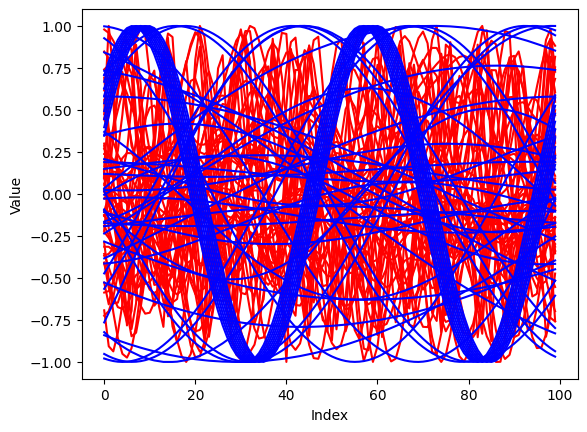

In [ ]:
norm = Normal(-1,1)
for f in files:
    train_samples,train_labels = read_data(f,1,100,100)
    norm.fit(train_samples)
    train_samples = norm.transform(train_samples)
    train_labels = norm.transform(train_labels)
    print(f"{f} MIN: {train_samples.min():.3f}, MAX: {train_samples.max():.3f}")
    for i in range(len(train_samples)):
        if f.startswith('C0'): color='red'
        if f.startswith('C1'): color='blue'
        plt.plot(train_samples[i,:],label=f"{f}",color=color)

plt.xlabel("Index")
plt.ylabel("Value")
plt.show()


## 4.1.2: Training models for each *normalised* signal in 200 epochs

2024-02-16 12:22:58.742590: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8100
2024-02-16 12:22:59.388676: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:630] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2024-02-16 12:22:59.412998: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x7f85f81b5480 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-02-16 12:22:59.413012: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): NVIDIA GeForce RTX 3060, Compute Capability 8.6
2024-02-16 12:22:59.426970: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-02-16 12:22:59.570091: I tensorflow/compiler/jit/xla_compilation_cache.cc:477] Compiled cluster using XLA!  This line is logged at most once for the lifetime of 

C0ModelHalvorsenA513-1 - avg loss 0.0107, final loss 0.0031
C0ModelHalvorsenA513-2 - avg loss 0.0109, final loss 0.0032
C0ModelHalvorsenA513-3 - avg loss 0.0090, final loss 0.0033
C0ModelHalvorsenA513-4 - avg loss 0.0099, final loss 0.0032
C0ModelHalvorsenA513-5 - avg loss 0.0050, final loss 0.0029
C0ModelHalvorsenA513-6 - avg loss 0.0095, final loss 0.0043
C0ModelHalvorsenA513-7 - avg loss 0.0101, final loss 0.0032
C0ModelHalvorsenA513-8 - avg loss 0.0065, final loss 0.0036
C0ModelHalvorsenA513-9 - avg loss 0.0050, final loss 0.0022
C0ModelHalvorsenA513-10 - avg loss 0.0065, final loss 0.0035
C0ModelLorenzA51-1 - avg loss 0.0240, final loss 0.0150
C0ModelLorenzA51-2 - avg loss 0.0320, final loss 0.0175
C0ModelLorenzA51-3 - avg loss 0.0176, final loss 0.0128
C0ModelLorenzA51-4 - avg loss 0.0244, final loss 0.0136
C0ModelLorenzA51-5 - avg loss 0.0202, final loss 0.0136
C0ModelLorenzA51-6 - avg loss 0.0176, final loss 0.0122
C0ModelLorenzA51-7 - avg loss 0.0296, final loss 0.0183
C0Model

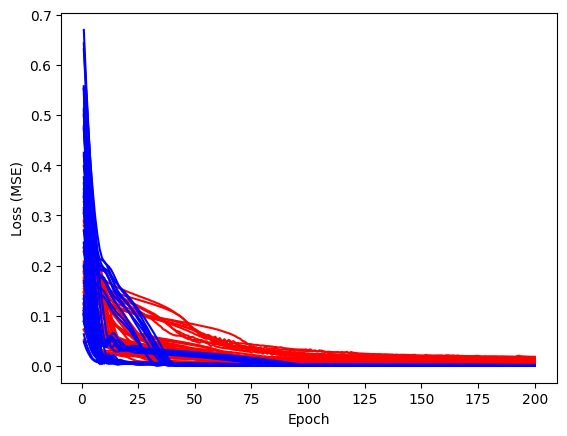

In [ ]:
norm = Normal(-1,1)

median_losses = {}
median_losses['c0'] = []
median_losses['c1'] = []

losses = {}

for f in files:
    for i in range(1,11):
        model = build_model()
        train_samples,train_labels = read_data(f,i)

        # normalisation of each signal
        norm.fit(train_samples)
        train_samples = norm.transform(train_samples)
        train_labels = norm.transform(train_labels)

        H = model.fit(train_samples,train_labels,epochs=EPOCHS,verbose=0,batch_size=64)
        losses[f"{f}_{i}"] = H.history['loss']
        epochs = range(1, len(H.history['loss']) + 1)
        if f.startswith('C0'):
            col='red'
            median_losses["c0"].append(median(H.history['loss']))
        if f.startswith('C1'):
            col='blue'
            median_losses["c1"].append(median(H.history['loss']))
        print(f"{f}_{i} - avg loss {median(H.history['loss']):.4f}, final loss {H.history['loss'][-1]:.4f}")
        plt.plot(epochs, H.history['loss'], label=f"{f}",color=col)
plt.xlabel("Epoch")
plt.ylabel("Loss (MSE)")


with open("median_losses_norm.json", "w") as outfile:
    json.dump(median_losses, outfile)

## Results saved in JSON file - will be used later in section 4.1.4!
with open("losses.json", "w") as outfile:
    json.dump(all_results, outfile)

mwg = mannwhitneyu(median_losses["c0"],median_losses["c1"],alternative='greater')
print('mann-whitney greater test=',mwg)


In [ ]:
# restore from file
import json
with open("median_losses_norm.json", 'r') as infile:
    data = json.load(infile)
median_losses = data

x = ttest_ind(median_losses['c0'],median_losses['c1'])
print('t-test=',x)

mw = mannwhitneyu(median_losses['c0'],median_losses['c1'])
print('mann-whitney test=',mw)

mwl = mannwhitneyu(median_losses['c0'],median_losses['c1'],alternative='less')
print('mann-whitney less test=',mwl)

mwg = mannwhitneyu(median_losses['c0'],median_losses['c1'],alternative='greater')
print('mann-whitney greater test=',mwg)

t-test= TtestResult(statistic=9.925021676450898, pvalue=1.760402970974987e-16, df=98.0)
mann-whitney test= MannwhitneyuResult(statistic=2464.0, pvalue=5.97842066997381e-17)
mann-whitney less test= MannwhitneyuResult(statistic=2464.0, pvalue=1.0)
mann-whitney greater test= MannwhitneyuResult(statistic=2464.0, pvalue=2.989210334986905e-17)


<span style="color:blue">Comment: it is still visible that for nonchaotic signals (blue) losses (mean squared errors) are lower than for chaotic signals (red)</span>

## 4.1.3 Checking the derivative of signals
We check the first derivate of the signals

In [ ]:
def diff(data):
    newdata = []
    for i in range(len(data)-1):
        newdata.append(data[i+1]-data[i])
    return newdata

C0ModelHalvorsenA513 (9, 100, 1)
C0ModelLorenzA51 (9, 100, 1)
C0ModelRoslerA52 (9, 100, 1)
C0ModelRucklideA515 (9, 100, 1)
C0ModelUedaA45 (9, 100, 1)
C1LinearOscBooming01 (9, 100, 1)
C1LinearOscFading01 (9, 100, 1)
C1LinearOscFading02 (9, 100, 1)
C1LinearOscillator01 (9, 100, 1)
C1LinearOscillator02 (9, 100, 1)


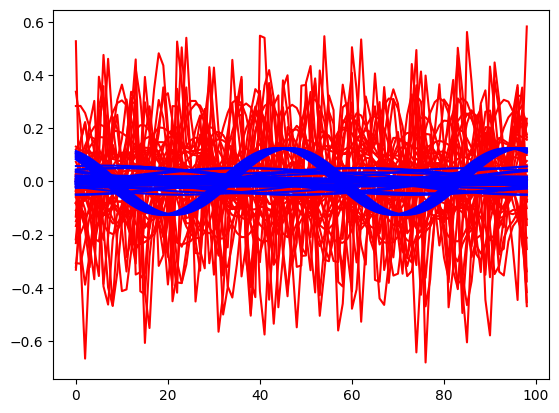

In [ ]:
for f in files:
    #train_samples,train_labels = read_data(f)
    train_samples,train_labels = read_data(f,1,100,100)
    print(f, train_samples.shape)
    norm.fit(train_samples)
    train_samples = norm.transform(train_samples)
    train_labels = norm.transform(train_labels)

    for i in range(len(train_samples)):
        if f.startswith('C0'): color='red'
        if f.startswith('C1'): color='blue'
        plt.plot(diff(train_samples[i,:]),label=f"{f}",color=color)
        ##plt.plot(train_samples[i,:],label=f"{f}",color=color)

Because the deravatives are higher for chaostic signal we take every 4th value from nonchaotic signal to increase the differences

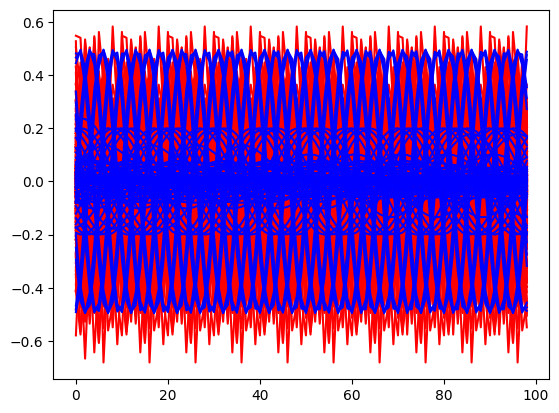

In [ ]:
for f in files:
    if f.startswith('C0'):
        train_samples,train_labels = read_data(f,1,100,10,1)
    else:
        train_samples,train_labels = read_data(f,1,100,10,4)

    norm.fit(train_samples)
    train_samples = norm.transform(train_samples)
    train_labels = norm.transform(train_labels)

    for i in range(len(train_samples)):
        if f.startswith('C0'): color='red'
        if f.startswith('C1'): color='blue'
        plt.plot(diff(train_samples[i,:]),label=f"{f}",color=color)
plt.show()

Now the deratives are *more or less* similar

## 4.1.3 Training models for each normalised signal taking every 4th value from nonchaotic signals to increase the signals' variability

C0ModelHalvorsenA513-1 - avg loss 0.0184, final loss 0.0055
C0ModelHalvorsenA513-2 - avg loss 0.0142, final loss 0.0026
C0ModelHalvorsenA513-3 - avg loss 0.0120, final loss 0.0058
C0ModelHalvorsenA513-4 - avg loss 0.0132, final loss 0.0068
C0ModelHalvorsenA513-5 - avg loss 0.0427, final loss 0.0077
C0ModelHalvorsenA513-6 - avg loss 0.0237, final loss 0.0072
C0ModelHalvorsenA513-7 - avg loss 0.0178, final loss 0.0051
C0ModelHalvorsenA513-8 - avg loss 0.0180, final loss 0.0061
C0ModelHalvorsenA513-9 - avg loss 0.0140, final loss 0.0030
C0ModelHalvorsenA513-10 - avg loss 0.0197, final loss 0.0087
C0ModelLorenzA51-1 - avg loss 0.0338, final loss 0.0123
C0ModelLorenzA51-2 - avg loss 0.0739, final loss 0.0213
C0ModelLorenzA51-3 - avg loss 0.0689, final loss 0.0157
C0ModelLorenzA51-4 - avg loss 0.0922, final loss 0.0161
C0ModelLorenzA51-5 - avg loss 0.0697, final loss 0.0233
C0ModelLorenzA51-6 - avg loss 0.0680, final loss 0.0544
C0ModelLorenzA51-7 - avg loss 0.0528, final loss 0.0350
C0Model

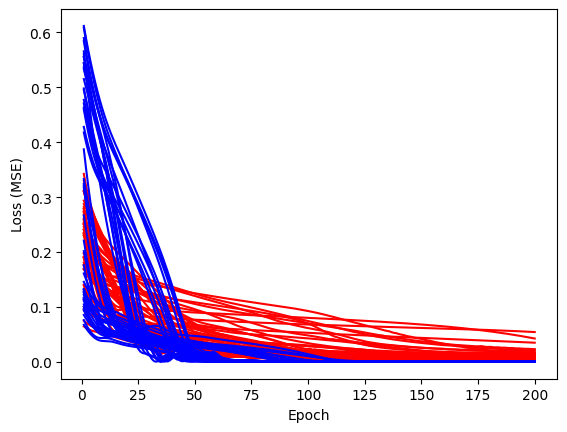

In [ ]:
norm = Normal(-1,1)
median_losses_c0 = []
median_losses_c1 = []
for f in files:
    for i in range(1,11):
        model = build_model()
        if f.startswith('C0'):
            train_samples,train_labels = read_data(f,i,10,5,1) #stride=5 to maintain the number of samples
        else:
            train_samples,train_labels = read_data(f,i,10,5,4)
        #print("Original size",train_samples.shape)
        train_samples = train_samples[:49,:,:]
        train_labels = train_labels[:49]
        #print("Used size",train_samples.shape)

        norm.fit(train_samples)
        train_samples = norm.transform(train_samples)
        train_labels = norm.transform(train_labels)

        H = model.fit(train_samples,train_labels,epochs=EPOCHS,verbose=0,batch_size=64)
        epochs = range(1, len(H.history['loss']) + 1)
        if f.startswith('C0'):
            col='red'
            median_losses_c0.append(median(H.history['loss']))
        if f.startswith('C1'):
            col='blue'
            median_losses_c1.append(median(H.history['loss']))
        plt.plot(epochs, H.history['loss'], label=f"({H.history['loss'][-1]:.4f})-{f}",color=col)
        print(f"{f}-{i} - avg loss {median(H.history['loss']):.4f}, final loss {H.history['loss'][-1]:.4f}")

plt.xlabel("Epoch")
plt.ylabel("Loss (MSE)")
#plt.legend(loc="upper right")

median_losses = {}
median_losses['c0'] = median_losses_c0
median_losses['c1'] = median_losses_c1

with open("median_losses_norm_deriv.json", "w") as outfile:
    json.dump(median_losses, outfile)

mwg = mannwhitneyu(median_losses['c0'],median_losses['c1'],alternative='greater')
print('mann-whitney greater test=',mwg)

# x = ttest_ind(median_losses_c0,median_losses_c1)
# print('t-test=',x)

# mw = mannwhitneyu(median_losses_c0,median_losses_c1)
# print('mann-whitney test=',mw)

In [ ]:
# restore from file
import json
with open("median_losses_norm_deriv.json", 'r') as infile:
    data = json.load(infile)
median_losses = data

x = ttest_ind(median_losses['c0'],median_losses['c1'])
print('t-test=',x)

mw = mannwhitneyu(median_losses['c0'],median_losses['c1'])
print('mann-whitney test=',mw)

mwl = mannwhitneyu(median_losses['c0'],median_losses['c1'],alternative='less')
print('mann-whitney less test=',mwl)

mwg = mannwhitneyu(median_losses['c0'],median_losses['c1'],alternative='greater')
print('mann-whitney greater test=',mwg)

t-test= TtestResult(statistic=8.059355732144104, pvalue=1.895035891086765e-12, df=98.0)
mann-whitney test= MannwhitneyuResult(statistic=2471.0, pvalue=3.9657464723536054e-17)
mann-whitney less test= MannwhitneyuResult(statistic=2471.0, pvalue=1.0)
mann-whitney greater test= MannwhitneyuResult(statistic=2471.0, pvalue=1.9828732361768027e-17)


## 4.1.4 Checking the repeatability of results for multiple signals of the same type
Because there are ten different files for each signal type we check if the results are similar for different signals of the same type

In [ ]:
# restore the results for normalised signals from file results200.json created above
import json
with open('losses.json', 'r') as infile:
    losses = json.load(infile)


C0ModelHalvorsenA513 ..........
C0ModelLorenzA51 ..........
C0ModelRoslerA52 ..........
C0ModelRucklideA515 ..........
C0ModelUedaA45 ..........
C1LinearOscBooming01 ..........
C1LinearOscFading01 ..........
C1LinearOscFading02 ..........
C1LinearOscillator01 ..........
C1LinearOscillator02 ..........


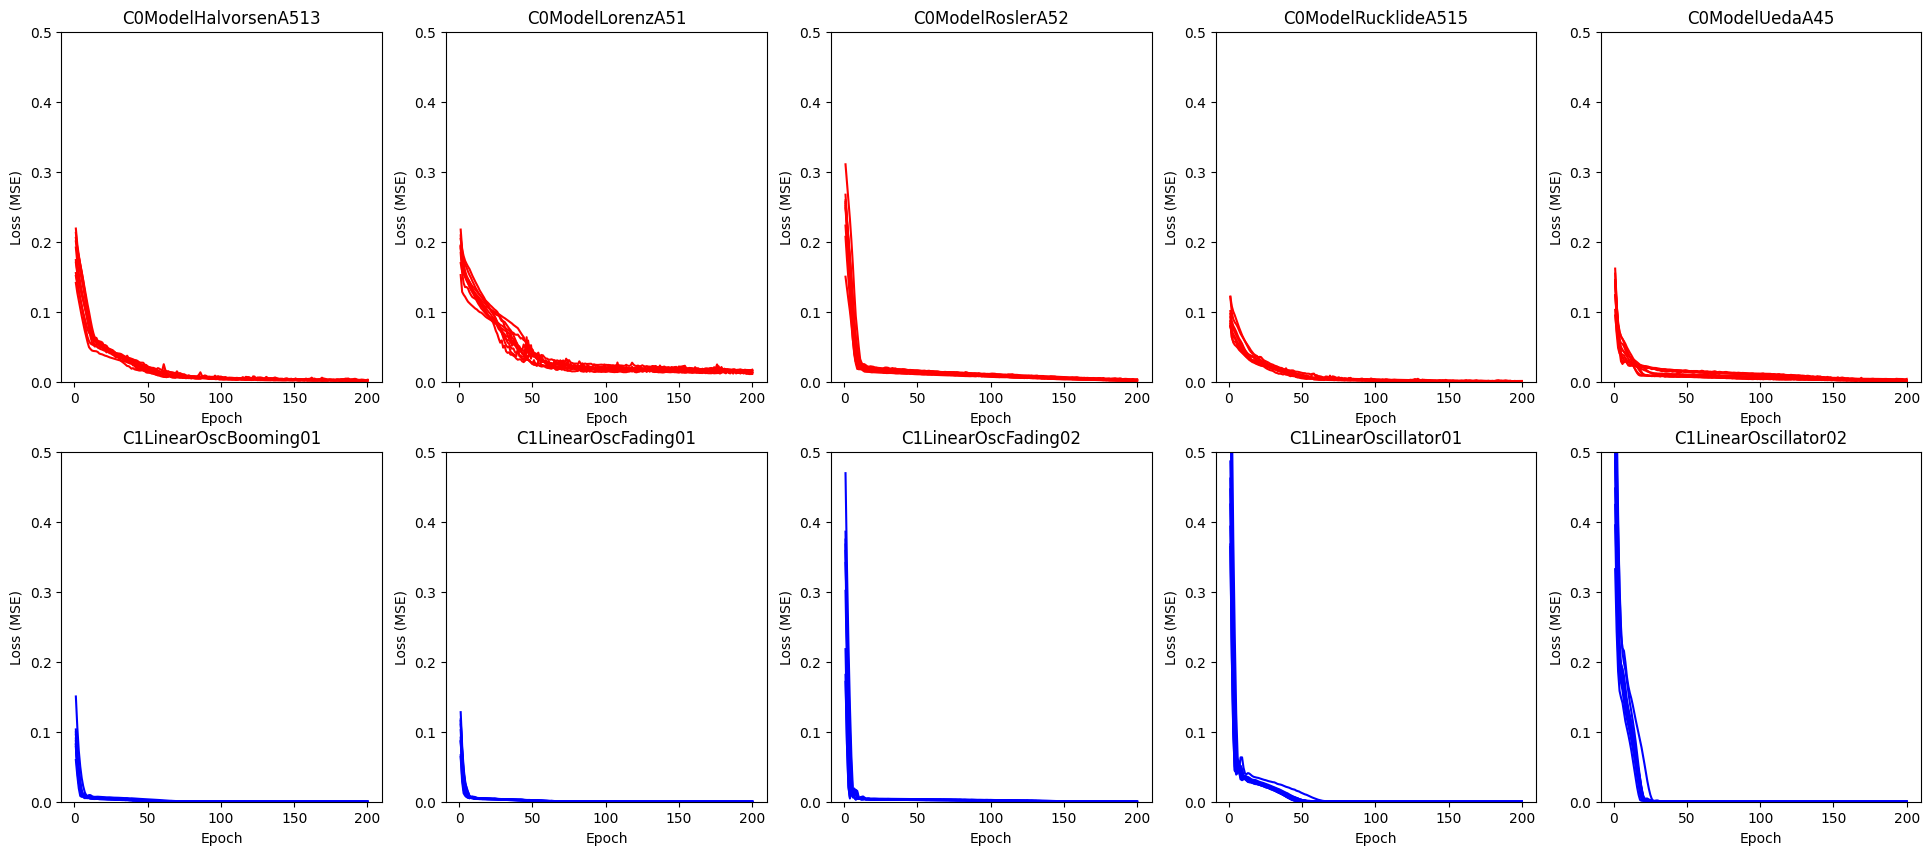

In [ ]:
plt.figure(figsize=(24, 10))

for n,f in enumerate(files):
    plt.subplot(2, 5, n + 1)
    print(f, end=" ")
    for i in range(1,11):
        loss = losses[f"{f}_{i}"]
        epochs = range(1, len(loss) + 1)
        if f.startswith('C0'): col='red'
        if f.startswith('C1'): col='blue'
        plt.plot(epochs, loss, color=col)
        print(".",end='')

    plt.ylim(0, 0.5)
    plt.title(f)
    plt.xlabel("Epoch")
    plt.ylabel("Loss (MSE)")
    print()

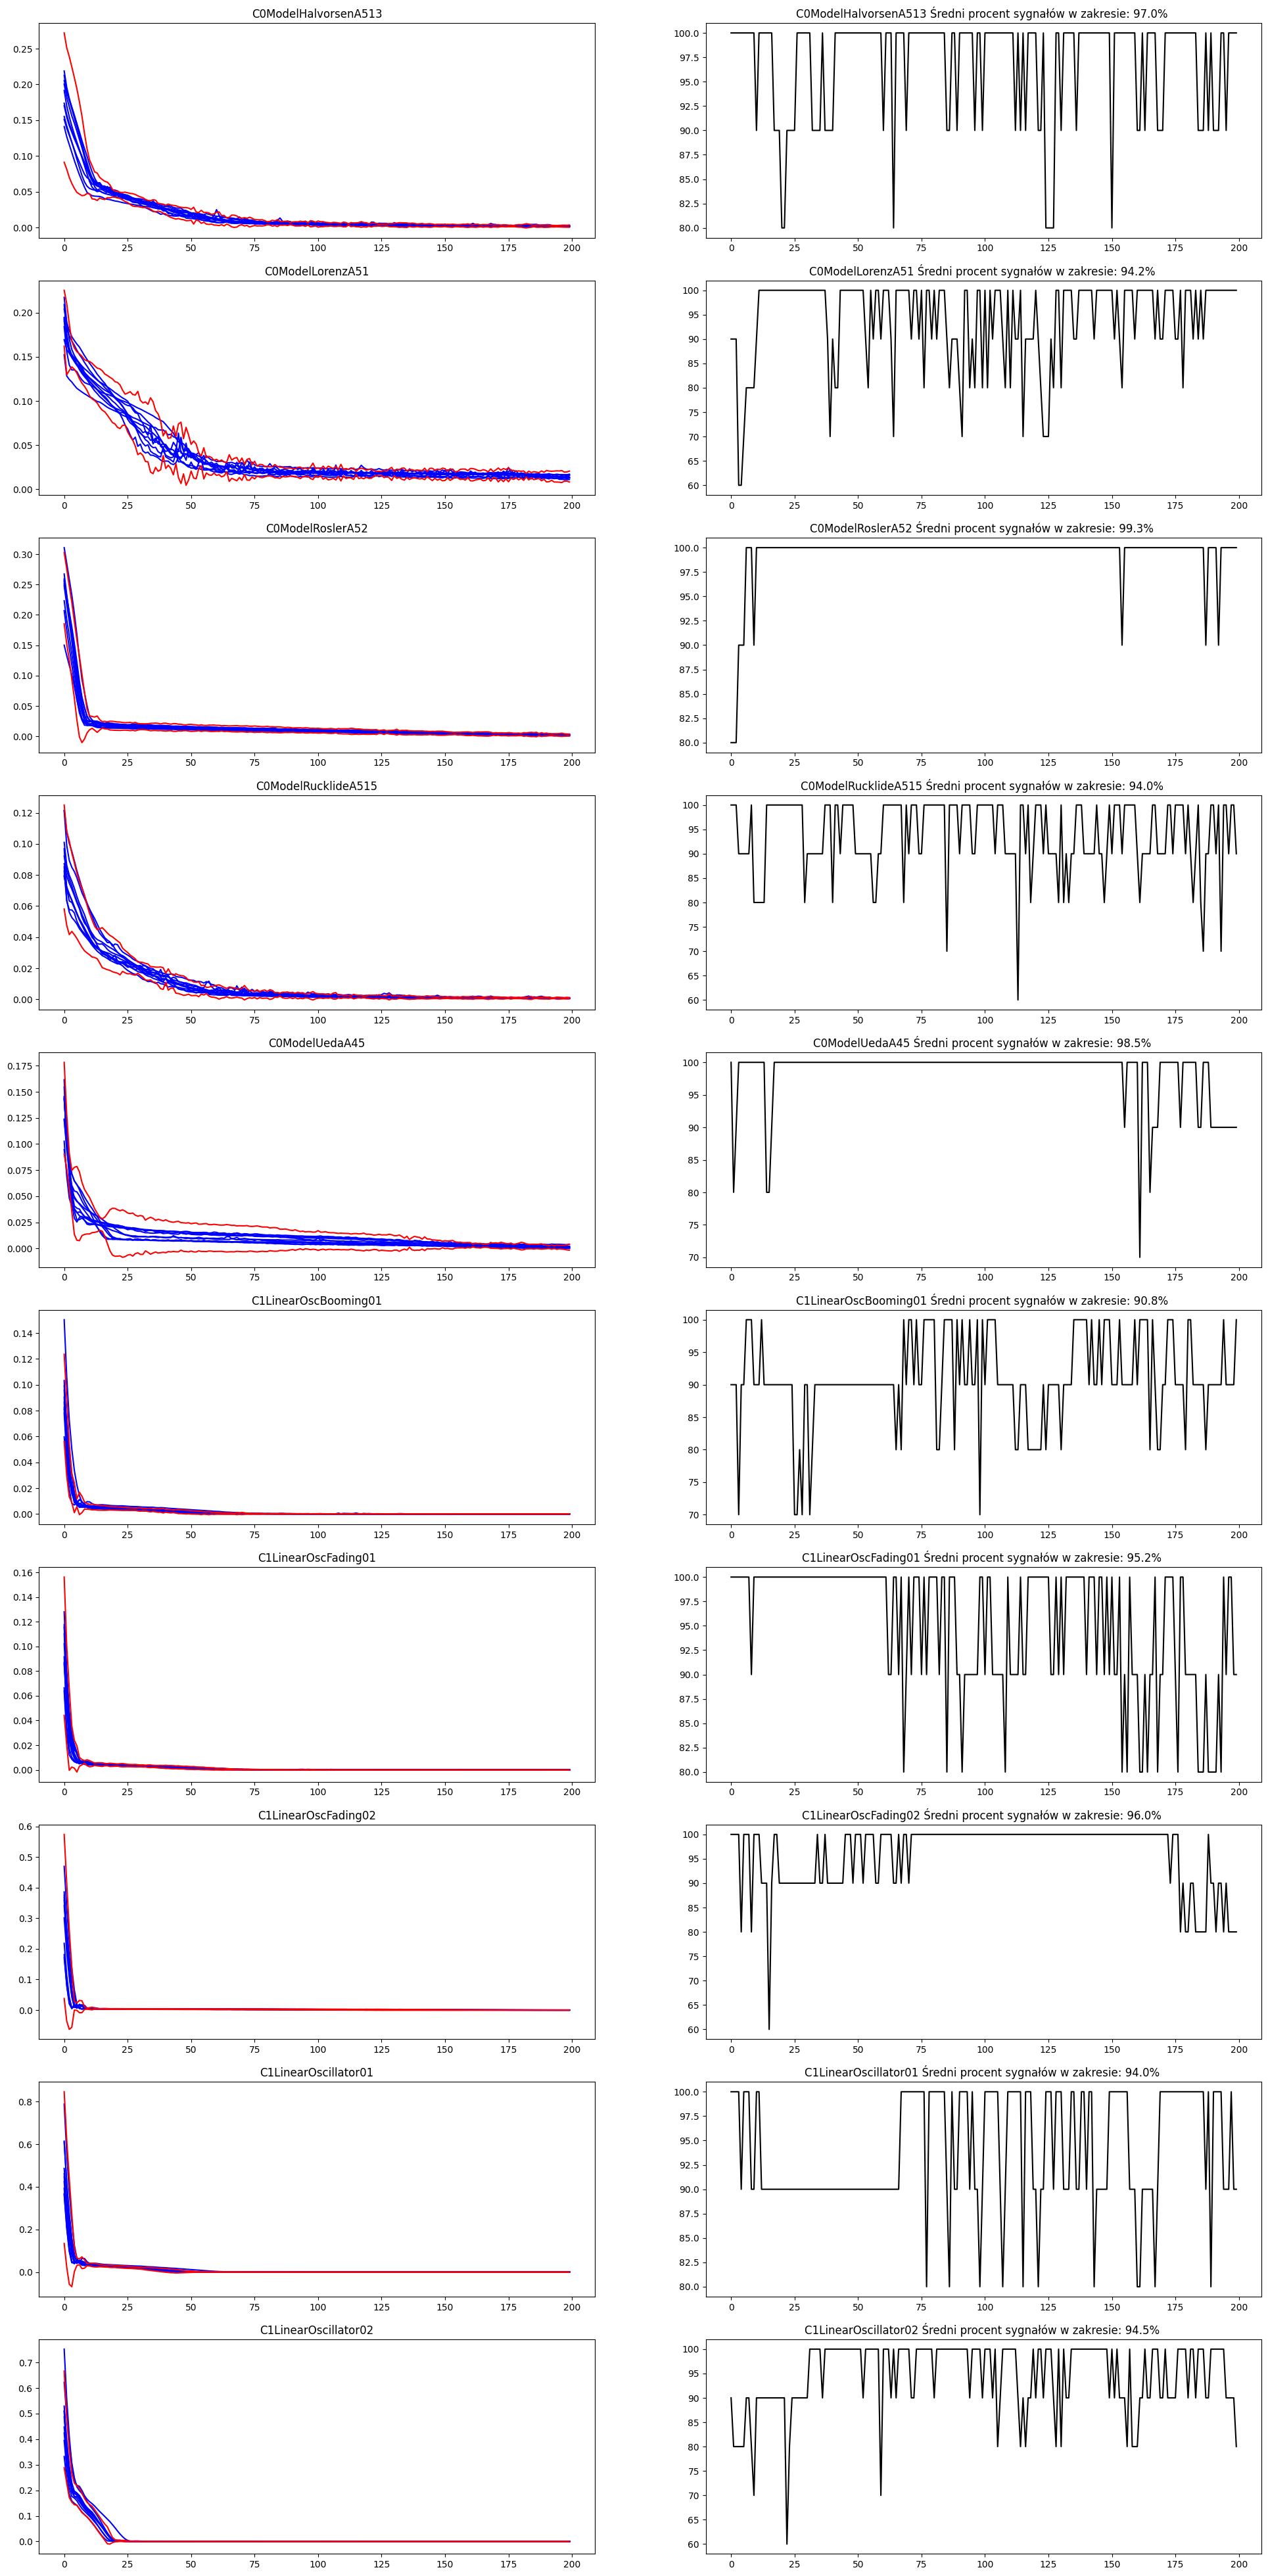

In [ ]:
###################
PROŚBA DO RAFAŁA O ZMIANĘ NA ANGIELSKIE KOMENTARZE!
###################

# Obliczenie "rozrzutu" sygnału   ROZWIĄZANIE NA KWANTYLACH
import json
from scipy.stats import norm
import math
import numpy as np
from matplotlib import pyplot as plt
ii = 1

plt.figure(figsize=(24, 50))

for f in files:

    plt.subplot(10, 2, ii)
    ii+=1
    plt.title(f)
    vals = np.zeros((200,10))
    lows = []
    highs = []
    in_ranges = []
    for i in range(1,11): ## grupuję dane z 10 plików
        key = f+"_"+str(i) ## pliki nazywają się NAZWA_i
        vals[:,i-1]=losses[key]
        plt.plot(losses[key],color='blue') # plot 10 sygnałów
    for i in range(200):
        mu, std = norm.fit(vals[i,:])
        #std = std/math.sqrt(10) # std średniej?
        coef = 3
        low = mu-std*coef # 3 x std?
        high = mu+std*coef
        low = np.percentile(vals[i,:], 25)
        high = mu+std*coef
        high = np.percentile(vals[i,:], 75)
        #IQR = norm.iqr(vals[i,:], interpolation = 'midpoint')
        IQR = high - low
        low = low - 1.5*IQR
        high = high + 1.5*IQR
        lows.append(low)
        highs.append(high)
        vv = vals[i,:]
        in_range = np.where(np.logical_and(vv>=low , vv<=high))
        in_ranges.append(len(in_range[0])) ## to jest liczba wartości z 10, które trafiają wewnątrz zakresu (low,high)
    plt.plot(lows,color='red') ## dorzucam zakresy górny i dolny na wykres
    plt.plot(highs,color='red')

    plt.subplot(10, 2, ii) ## drugi wykres z liczbami sygnałów wewnątrz zakresu (mean-std*3,mean+std*3)
    ii+=1
    ir = np.array(in_ranges)*10 ## przerabiam na procent (jest 10 sygnałów)
    plt.title(f'{f} Średni procent sygnałów w zakresie: {np.mean(ir):.1f}% ')

    plt.plot(ir,color='black')
#     #print()
#     #print (std)
#     jj = 0
#     for j in range(200):
#     #  if in_ranges
# #        print (ir[j]> 75)
#         if ir[j]> 80:
#            jj = jj + 1

<span style="color:blue">Comment: Model trained on different signals of the same type has similar values of the loss function - however, the differences for chaotic signals are bigger.</span>

### Final conclusion for H1:
<span style="color:blue">It is visible that the model learns deterministic signals faster than the chaotic ones. The median of the losses is significantly lower for signals taken from the dataset as well as for the normalised signals and signals with similar variability. Additionally, for signals of the same type the results are comparable. **Therefore, it should be possible to measure the level of signal chaoticness by analysing the losses**.</span>


# Checking H2
# After some number of iterations it is possible to find a measure that ideally separates deterministic and chaotic signals based on training loss values.


# 4.2 Finding the measure that may be used to calculate the determinism

Algorithm:

For all 100 data files (10 types and 10 signals for each):
- divide into chunks of 10 signals + 11th signal as label (with stride=5, some overlap between signals)
- fit the model for 200 epochs and register losses
- save losses as a vector of 200 values

In [ ]:
EPOCHS=200
normal = Normal(-1,1)
all_results = {}
print("model_ver: (initial_loss -> final_loss)")
for f in files:
    for n in range(1,11):
#for d in dirs:
        model = build_model()
        train_samples,train_labels = read_data(f,n,10,5)

        normal.fit(train_samples)
        train_samples = norm.transform(train_samples)
        train_labels = norm.transform(train_labels)

        H = model.fit(train_samples,train_labels,epochs=EPOCHS,verbose=0,batch_size=64)
        epochs = range(1, len(H.history['loss']) + 1)
        results = H.history['loss'].copy()
        all_results[f"{f}_{n}"] = results
        print(f"{f}_{n}: ({H.history['loss'][0]:.4f} -> {H.history['loss'][-1]:.4f})")
print('done')

model_ver: (initial_loss -> final_loss)
C0ModelHalvorsenA513_1: (0.2188 -> 0.0026)
C0ModelHalvorsenA513_2: (0.1917 -> 0.0015)
C0ModelHalvorsenA513_3: (0.2055 -> 0.0025)
C0ModelHalvorsenA513_4: (0.1412 -> 0.0018)
C0ModelHalvorsenA513_5: (0.2127 -> 0.0025)
C0ModelHalvorsenA513_6: (0.1703 -> 0.0020)
C0ModelHalvorsenA513_7: (0.1738 -> 0.0015)
C0ModelHalvorsenA513_8: (0.1553 -> 0.0021)
C0ModelHalvorsenA513_9: (0.1511 -> 0.0018)
C0ModelHalvorsenA513_10: (0.2005 -> 0.0016)
C0ModelLorenzA51_1: (0.1947 -> 0.0138)
C0ModelLorenzA51_2: (0.1905 -> 0.0156)
C0ModelLorenzA51_3: (0.2174 -> 0.0165)
C0ModelLorenzA51_4: (0.2040 -> 0.0127)
C0ModelLorenzA51_5: (0.1926 -> 0.0129)
C0ModelLorenzA51_6: (0.1524 -> 0.0111)
C0ModelLorenzA51_7: (0.2091 -> 0.0161)
C0ModelLorenzA51_8: (0.1936 -> 0.0171)
C0ModelLorenzA51_9: (0.1843 -> 0.0129)
C0ModelLorenzA51_10: (0.1695 -> 0.0133)
C0ModelRoslerA52_1: (0.2672 -> 0.0022)
C0ModelRoslerA52_2: (0.1501 -> 0.0011)
C0ModelRoslerA52_3: (0.2568 -> 0.0023)
C0ModelRoslerA52_4: (

In [ ]:
## Results saved in JSON file - will be used later!
with open("results200.json", "w") as outfile:
    json.dump(all_results, outfile)

## Check the loss for the last (200) epoch

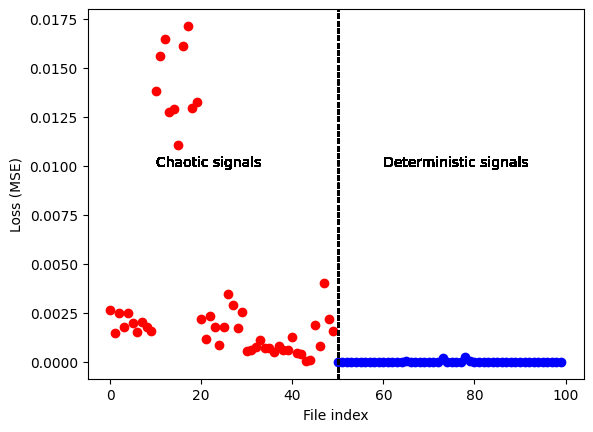

In [ ]:
for i,r in enumerate(all_results):
    if r.startswith('C0'): color='red'
    if r.startswith('C1'): color='blue'
    plt.xlabel("File index")
    plt.ylabel("Loss (MSE)")
    plt.text(x=10,y=0.01,s="Chaotic signals",fontsize="medium")# ,color="red")
    plt.text(x=60,y=0.01,s="Deterministic signals",fontsize="medium")#,color="blue")
    plt.axvline(x = 50, linewidth=1, color = 'black', label = 'threshold', ls='dashed')
    plt.scatter(i, all_results[r][-1], label=f"{r}",color=color)

<span style="color:blue">Comment: It is not completely separable but it is visible that losses for chaotic signals are higher</span>

## Turn the list of values to probability distribution

In [ ]:
probs = {}
for r in all_results:
    x = np.array(all_results[r])
    x = x/np.sum(x)
    probs[r]=x

probs - distributions

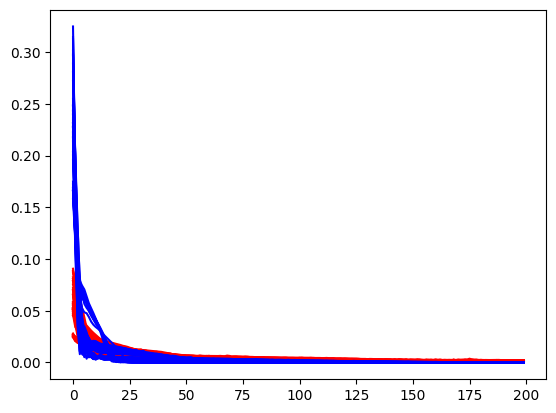

In [ ]:
for r in probs:
    if r.startswith('C0'): color='red'
    if r.startswith('C1'): color='blue'
    plt.plot(range(len(probs[r])), probs[r], label=f"{r}",color=color)

## 4.2.1 Calculation of medmax for each signal (median_value/max_value)

In [ ]:
def calc_medmax(x):
    med = np.median(x)
    max = np.max(x)
    return med/max

def calc_medmax_epochs(probs,epochs):
    medmax = {}
    for f in files:
        medmax[f]=[]
        for n in range(1,11):
            medmax[f].append(calc_medmax(probs[f+'_'+str(n)][:epochs]))
    return medmax

### Analysis of medmax values for epochs=10,20,30,....200 (not in the paper!)

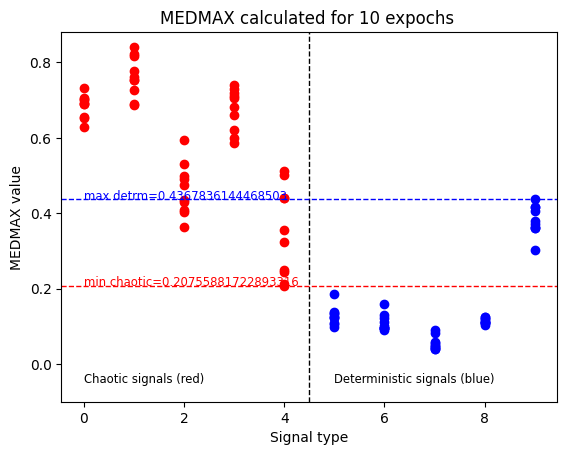

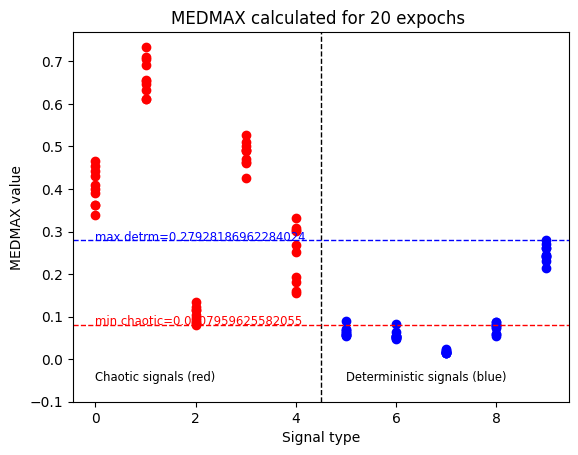

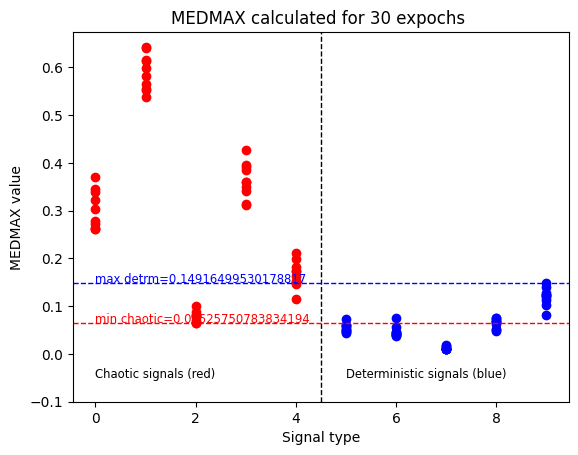

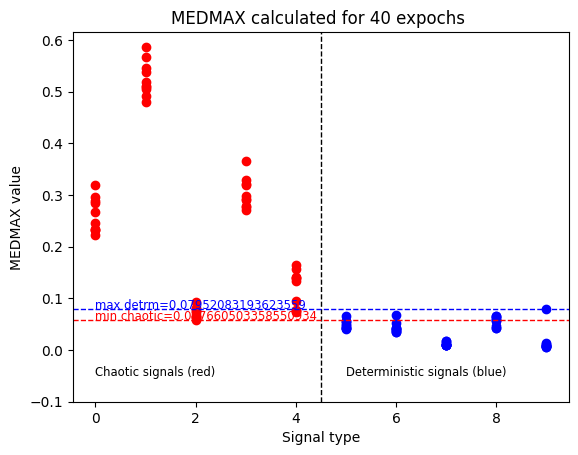

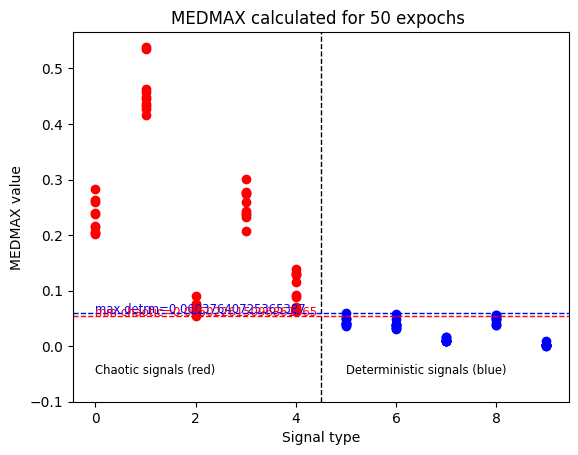

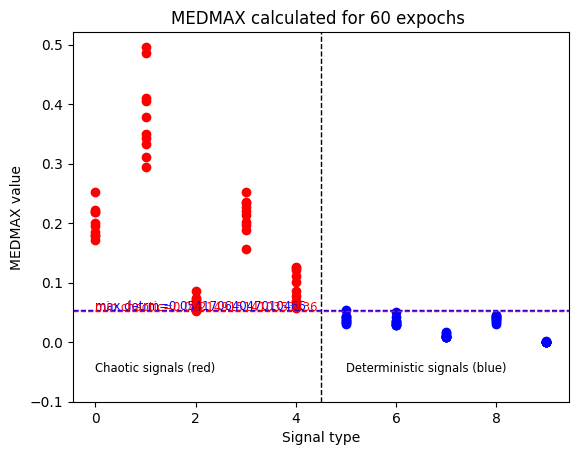

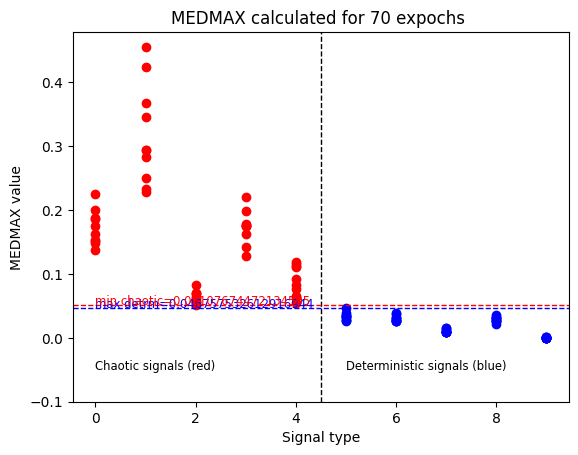

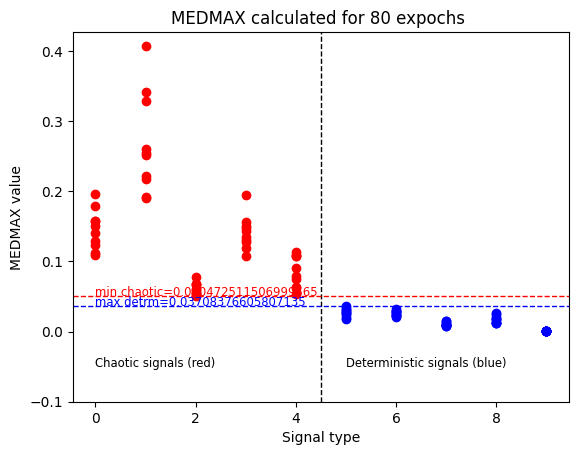

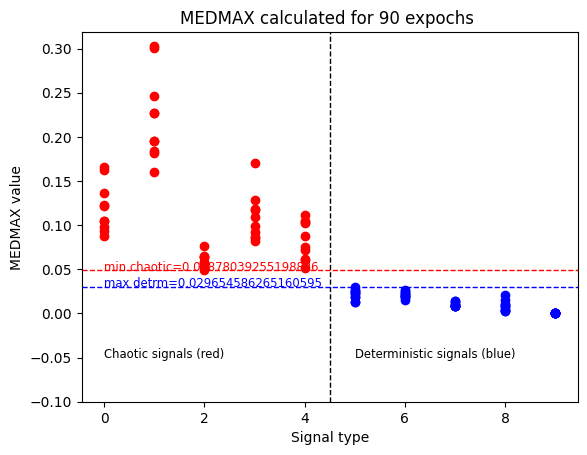

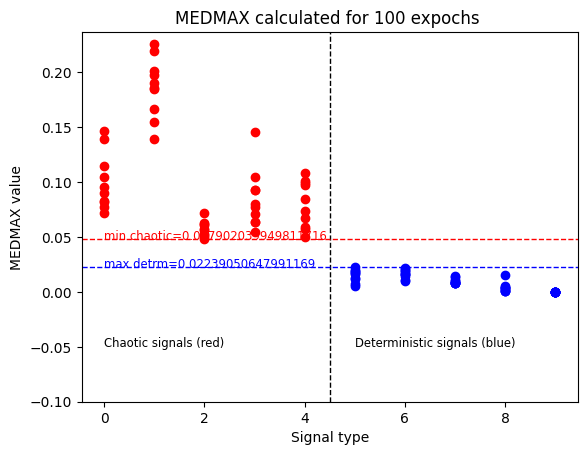

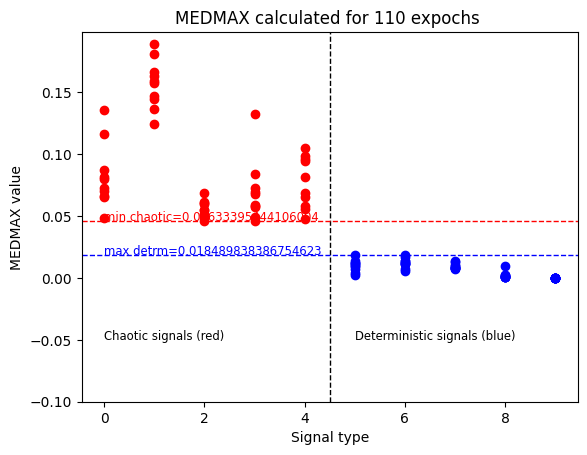

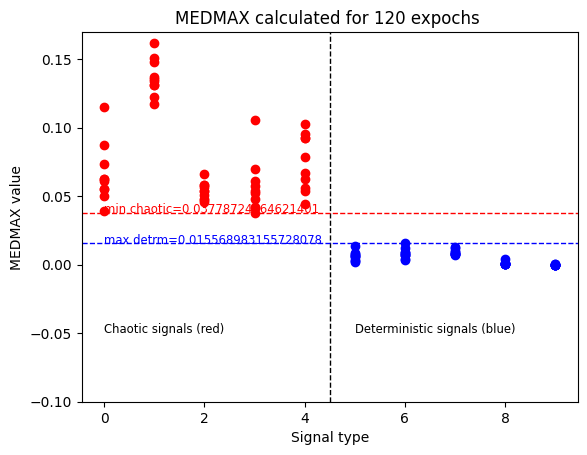

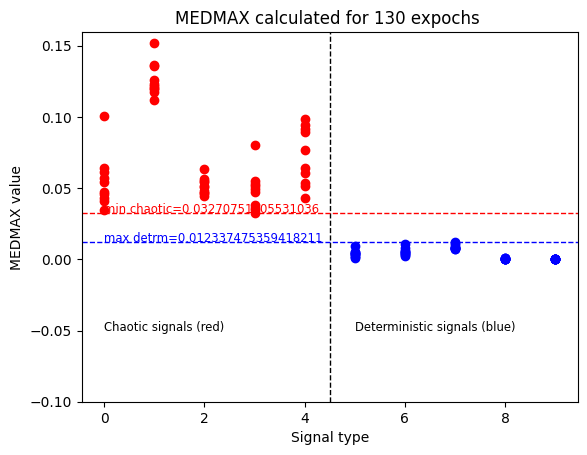

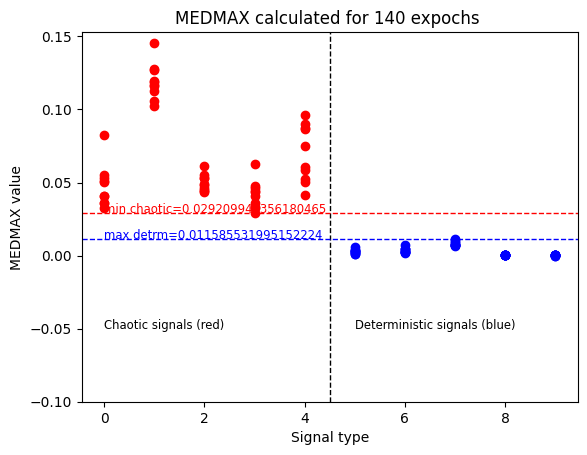

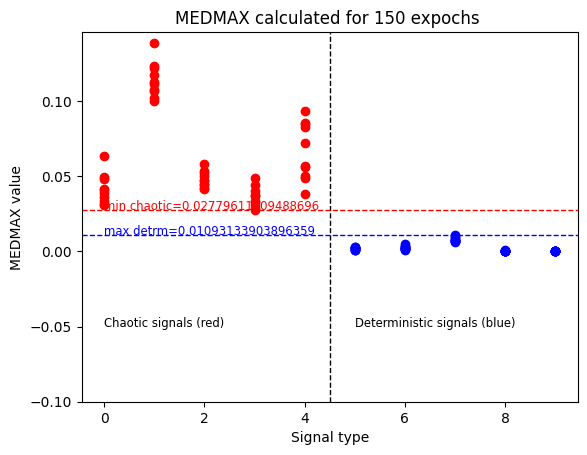

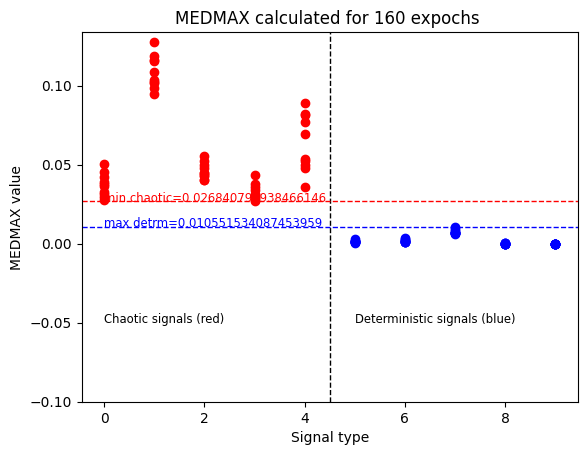

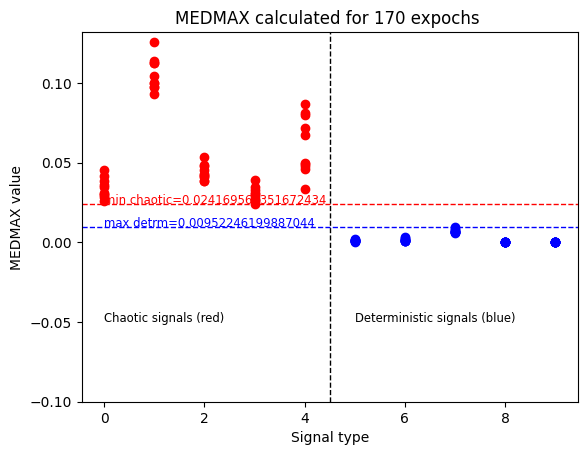

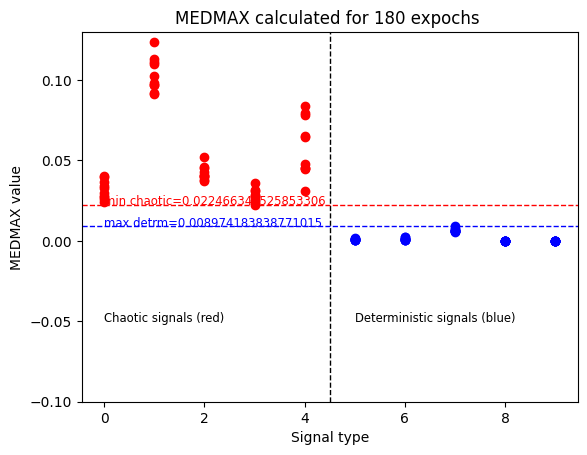

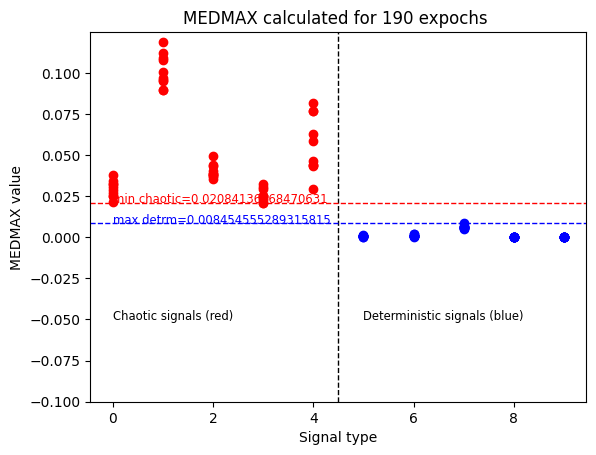

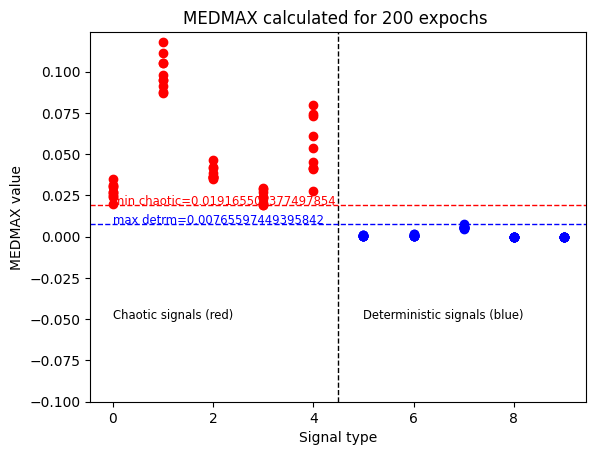

In [ ]:
medmax = {}
for scope in range(10,201,10):
    min_c0 = 1
    max_c1 = 0
    for f in files:
        medmax[f]=[]
        for n in range(1,11):
            medmax[f].append(calc_medmax(probs[f+'_'+str(n)][:scope]))
    for i,r in enumerate(medmax):
        if r.startswith('C0'): color='red'
        if r.startswith('C1'): color='blue'
        for j in range(10):
            plt.scatter(i, medmax[r][j], label=f"{f}",color=color)
            if medmax[r][j]<min_c0 and r.startswith('C0'):
                min_c0 = medmax[r][j]
            if medmax[r][j]>max_c1 and r.startswith('C1'):
                max_c1 = medmax[r][j]

    plt.ylim(bottom=-0.1)
    plt.text(x=0,y=-0.05,s="Chaotic signals (red)",fontsize="small")# ,color="red")
    plt.text(x=5,y=-0.05,s="Deterministic signals (blue)",fontsize="small")#,color="blue")
    plt.axvline(x = 4.5, linewidth=1, color = 'black', label = 'threshold', ls='dashed')

    plt.axhline(y = max_c1, linewidth=1, color = 'blue', label = 'max_c1', ls='dashed')
    plt.text(x=0,y= max_c1,s=f"max detrm={max_c1}",fontsize="small",color="blue")
    plt.axhline(y = min_c0, linewidth=1, color = 'red', label = 'min_c0', ls='dashed')
    plt.text(x=0,y= min_c0,s=f"min chaotic={min_c0}",fontsize="small",color="red")
    plt.xlabel("Signal type")
    plt.ylabel("MEDMAX value")
    plt.title(f"MEDMAX calculated for {scope} expochs ")
    plt.show()

## 4.2.2 Finding the best number of epochs

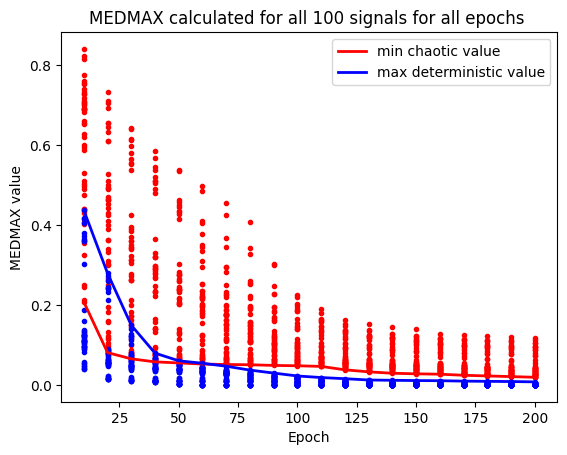

In [ ]:
mins_c0 = []
maxs_c1 = []
for scope in range(10,201,10):
    min_c0 = 1
    max_c1 = 0
    for f in files:
        medmax[f]=[]
        for n in range(1,11):
            medmax[f].append(calc_medmax(probs[f+'_'+str(n)][:scope]))
    for i,r in enumerate(medmax):
        if r.startswith('C0'): color='red'
        if r.startswith('C1'): color='blue'
        for j in range(10):
            plt.scatter(scope, medmax[r][j],color=color,marker='.',label='_nolegend_')
            if medmax[r][j]<min_c0 and r.startswith('C0'):
                min_c0 = medmax[r][j]
            if medmax[r][j]>max_c1 and r.startswith('C1'):
                max_c1 = medmax[r][j]
    mins_c0.append(min_c0)
    maxs_c1.append(max_c1)

plt.plot(range(10,201,10),mins_c0,color='red',linewidth=2,label="min chaotic value")
plt.plot(range(10,201,10),maxs_c1,color='blue',linewidth=2,label="max deterministic value")
plt.xlabel("Epoch")
plt.ylabel("MEDMAX value")
plt.title(f"MEDMAX calculated for all 100 signals for all epochs ")
plt.legend(loc="upper right")
plt.show()

### Distribution of medmax values for 100 epochs all signals

Text(0, 0.5, 'MEDMAX value')

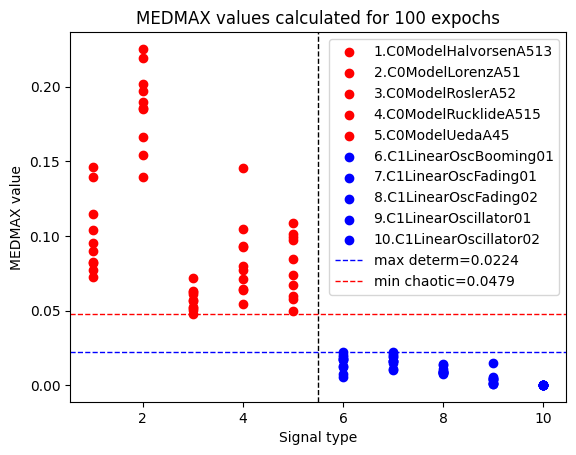

In [ ]:
medmax = calc_medmax_epochs(probs,100)
min_c0 = 1
max_c1 = 0
for i,r in enumerate(medmax):
    if r.startswith('C0'): color='red'
    if r.startswith('C1'): color='blue'
    for j in range(10):
        if j==0:
            lab = f"{i+1}.{r}"
        else:
            lab = '_nolegend_'
        plt.scatter(i+1, medmax[r][j], label=lab,color=color)
        if medmax[r][j]<min_c0 and r.startswith('C0'):
            min_c0 = medmax[r][j]
        if medmax[r][j]>max_c1 and r.startswith('C1'):
            max_c1 = medmax[r][j]



plt.axvline(x = 5.5, linewidth=1, color = 'black', label = '_nolegend_', ls='dashed')

plt.axhline(y = max_c1, linewidth=1, color = 'blue', label = f'max determ={max_c1:.4f}', ls='dashed')
#plt.text(x=1.2,y= max_c1,s=f"max determ = {max_c1:.4f}",fontsize="small",color="blue")
plt.axhline(y = min_c0, linewidth=1, color = 'red', label = f'min chaotic={min_c0:.4f}', ls='dashed')
#plt.text(x=1.2,y= min_c0,s=f"min chaotic = {min_c0:.4f}",fontsize="small",color="red")
plt.title(f"MEDMAX values calculated for 100 expochs")


plt.legend(loc="upper right")
plt.xlabel("Signal type")
plt.ylabel("MEDMAX value")
    #print(r, all_results[r][-1])

<span style="color:blue">Comment: values are linearily separable!</span>

<span style="color:blue">Comment: C1LinearOscilalator02 characterizes with very low standard deviation (see also below)</span>

In [ ]:
with open("medmax100.json", "w") as outfile:
    json.dump(medmax, outfile)

# 4.3. Checking H3:
# It is possible to automatically determine a threshold value of this measure that separates deterministic and chaotic signals

## 4.3.1 Searching for the threshold value separating signals using per-signal-type crossvalidation

Algorithm:
- Divide all signal types into distinctive folds
- Find the best threshold value using signals from all folds but one
- Apply this threshold for signals from the outstanding fold
- Calculate accuracy (precision, recall...)

Threshold calculation based on training data:
- Create two distributions: separately for C0 and for C1
- Find intersection point for these distributions
- medmax value for this intersection will be the threshold

Two methods of distribution plotting:
1. Kernel Desity Estimation using Gaussian kernel (KDE)
2. Approximation to normal distribution (NORM)

In [ ]:
### Kernel Desity Estimation (KDE)
from scipy.stats import norm,gaussian_kde

def find_threshold_kde(c0,c1):
    gkde0 = gaussian_kde(c0)
    gkde1 = gaussian_kde(c1)
    fn = lambda x: gkde1(x)-gkde0(x)
    return find_root(min(c1),fn)

def find_root(start,fun,step=.0001):
    x = start
    while fun(x)>0:
        x = x+step
    return x

In [ ]:
### Approximation to normal distribution (NORM)

# https://stackoverflow.com/a/22579904/13467454
# finds intersections of two normal distributions
def find_intersection(m1,m2,std1,std2):
  a = 1/(2*std1**2) - 1/(2*std2**2)
  b = m2/(std2**2) - m1/(std1**2)
  c = m1**2 /(2*std1**2) - m2**2 / (2*std2**2) - np.log(std2/std1)
  return np.roots([a,b,c])

# finds threshold as the point of intersection between two normal distributions created for c0 and c1
def find_threshold_norm(c0,c1):
    mu0, std0 = norm.fit(c0)
    mu1, std1 = norm.fit(c1)
    return find_intersection(mu0,mu1,std0,std1)

In [ ]:
# shows two normal distributions and two density distributions
def show_plot(c0,c1):
    x = np.linspace(-0.01, 0.4, 1000)

    # NORM part
    threshold_norm = find_threshold_norm(c0,c1)

    mu0, std0 = norm.fit(c0)
    mu1, std1 = norm.fit(c1)
    p0 = norm.pdf(x, mu0, std0)
    p1 = norm.pdf(x, mu1, std1)
    plt.plot(x, p0, linewidth=1,color='red',label="chaotic signals distribution")
    plt.plot(x, p1, linewidth=1,color='blue',label="deterministic signals distribution")
    plt.axvline(x = max(threshold_norm), linewidth=1, ls='dashed', label = f'threshold_norm={max(threshold_norm):.5f}')
    #plt.plot(max(result),norm.pdf(max(result),mu1,std1),'o')

    # KDE part
    threshold_kde = find_threshold_kde(c0,c1)

    gkde0 = gaussian_kde(c0)
    gkde1 = gaussian_kde(c1)
    plt.plot(x,gkde0(x),label="chaotic KDE distribution")
    plt.plot(x,gkde1(x),label="deterministic KDE distribution")
    plt.axvline(x = threshold_kde, linewidth=1, ls='dotted', label = f'threshold_kde={threshold_kde:.5f}')

    plt.xlabel("MEDMAX value")
    plt.ylabel("Distribution")


# calculates accuracy for the given threshold
def calc_results(c0,c1,threshold):
    v0 = np.where(np.array(c0) >= threshold ,1, 0)
    v1 = np.where(np.array(c1) >= threshold ,1, 0)
    l0 = [1]*len(c0)
    l1 = [0]*len(c1)
    r = list(v0)+list(v1)
    l = l0+l1
    print("Ground truth :",l)
    print("Model's answer:",r)

    print(confusion_matrix(l, r))
    return accuracy_score(l, r)

# splits all data into train and test sets (train - list of type names to take as training set)
def train_test_split(train):
    train_c0 = []
    train_c1 = []
    test_c0 = []
    test_c1 = []

    for r in medmax:
        if r.startswith(tuple(train)):
            if r.startswith('C0'):
                train_c0.extend(medmax[r])
            else:
                train_c1.extend(medmax[r])
        else:
            if r.startswith('C0'):
                test_c0.extend(medmax[r])
            else:
                test_c1.extend(medmax[r])
    return train_c0,train_c1,test_c0,test_c1

## Experiment for all samples - no division into training and test sets

Ground truth : [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Model answer: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[[50  0]
 [ 0 50]]
Accuracy: 100.0


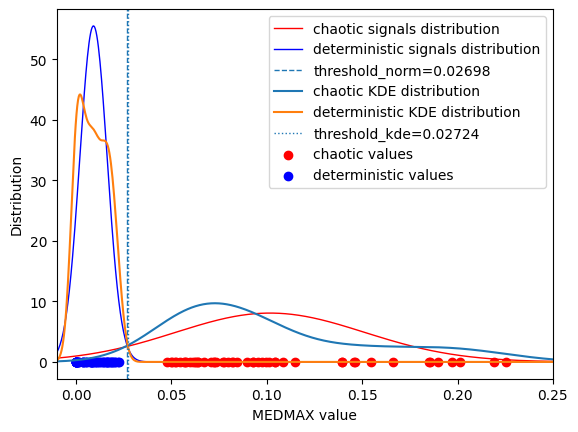

In [ ]:
from scipy.stats import norm,gaussian_kde
#del(max)
c0_files = [f for f in files if f.startswith('C0')]
c1_files = [f for f in files if f.startswith('C1')]
train = files
train_c0,train_c1,test_c0,test_c1 = train_test_split(train) # no split here!
t = find_threshold(train_c0,train_c1)
show_plot(train_c0,train_c1)

a = calc_results(train_c0,train_c1,max(t))
print("Accuracy:",a*100)
plt.scatter(train_c0,np.zeros_like(train_c0),color='red',label="chaotic values")
plt.scatter(train_c1,np.zeros_like(train_c0),color='blue',label="deterministic values")
plt.xlim(-0.01,0.25)
plt.legend(loc="upper right")
plt.show()

## Leave-one-type-out crossvalidation
One type is always tested and the threshold is calculated using data from all other files

Train types: ['C0ModelLorenzA51', 'C0ModelRoslerA52', 'C0ModelRucklideA515', 'C0ModelUedaA45', 'C1LinearOscBooming01', 'C1LinearOscFading01', 'C1LinearOscFading02', 'C1LinearOscillator01', 'C1LinearOscillator02']
Tested type: C0ModelHalvorsenA513


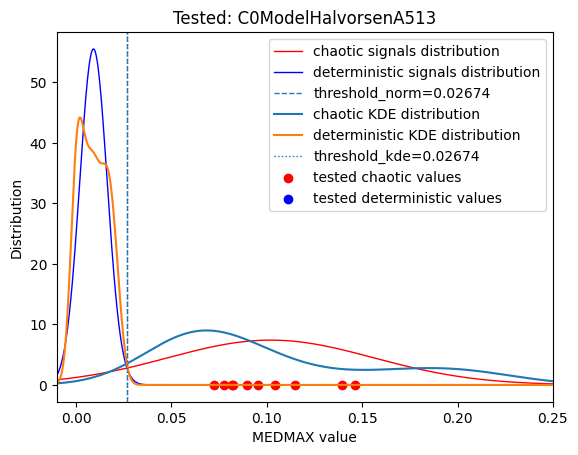

Threshold: 0.026740467222901403
Ground truth : [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
Model answer: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
[[10]]
Accuracy: 100.0
Train types: ['C0ModelHalvorsenA513', 'C0ModelRoslerA52', 'C0ModelRucklideA515', 'C0ModelUedaA45', 'C1LinearOscBooming01', 'C1LinearOscFading01', 'C1LinearOscFading02', 'C1LinearOscillator01', 'C1LinearOscillator02']
Tested type: C0ModelLorenzA51


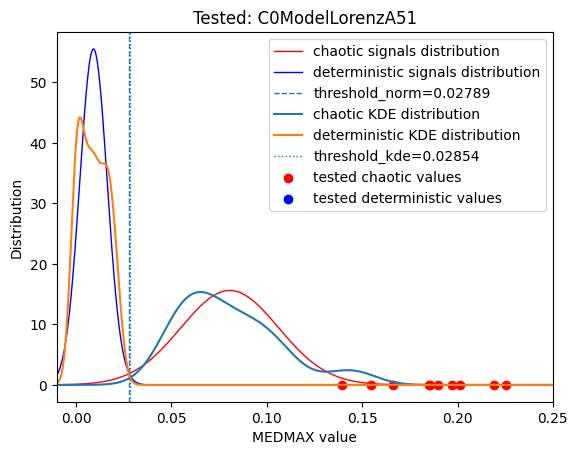

Threshold: 0.02788710648504531
Ground truth : [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
Model answer: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
[[10]]
Accuracy: 100.0
Train types: ['C0ModelHalvorsenA513', 'C0ModelLorenzA51', 'C0ModelRucklideA515', 'C0ModelUedaA45', 'C1LinearOscBooming01', 'C1LinearOscFading01', 'C1LinearOscFading02', 'C1LinearOscillator01', 'C1LinearOscillator02']
Tested type: C0ModelRoslerA52


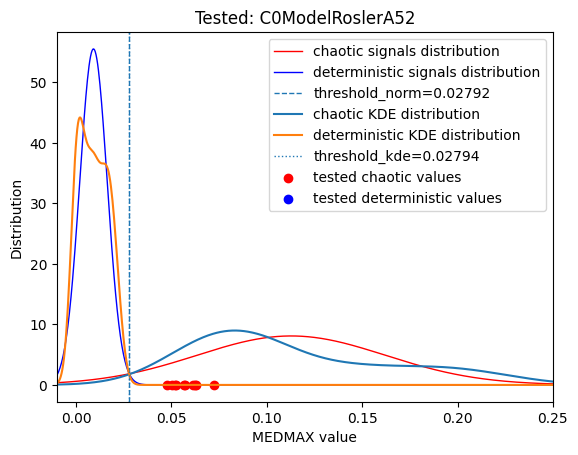

Threshold: 0.027922177184584812
Ground truth : [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
Model answer: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
[[10]]
Accuracy: 100.0
Train types: ['C0ModelHalvorsenA513', 'C0ModelLorenzA51', 'C0ModelRoslerA52', 'C0ModelUedaA45', 'C1LinearOscBooming01', 'C1LinearOscFading01', 'C1LinearOscFading02', 'C1LinearOscillator01', 'C1LinearOscillator02']
Tested type: C0ModelRucklideA515


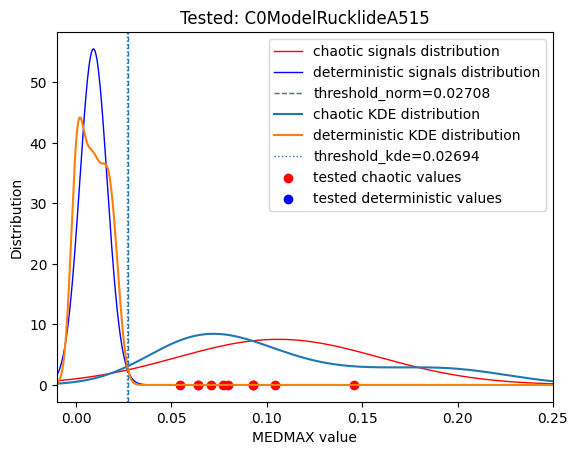

Threshold: 0.0270801944265099
Ground truth : [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
Model answer: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
[[10]]
Accuracy: 100.0
Train types: ['C0ModelHalvorsenA513', 'C0ModelLorenzA51', 'C0ModelRoslerA52', 'C0ModelRucklideA515', 'C1LinearOscBooming01', 'C1LinearOscFading01', 'C1LinearOscFading02', 'C1LinearOscillator01', 'C1LinearOscillator02']
Tested type: C0ModelUedaA45


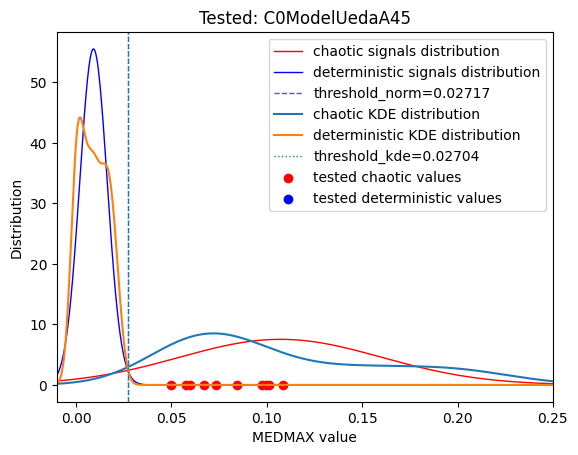

Threshold: 0.027170715775178662
Ground truth : [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
Model answer: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
[[10]]
Accuracy: 100.0
Train types: ['C0ModelHalvorsenA513', 'C0ModelLorenzA51', 'C0ModelRoslerA52', 'C0ModelRucklideA515', 'C0ModelUedaA45', 'C1LinearOscFading01', 'C1LinearOscFading02', 'C1LinearOscillator01', 'C1LinearOscillator02']
Tested type: C1LinearOscBooming01


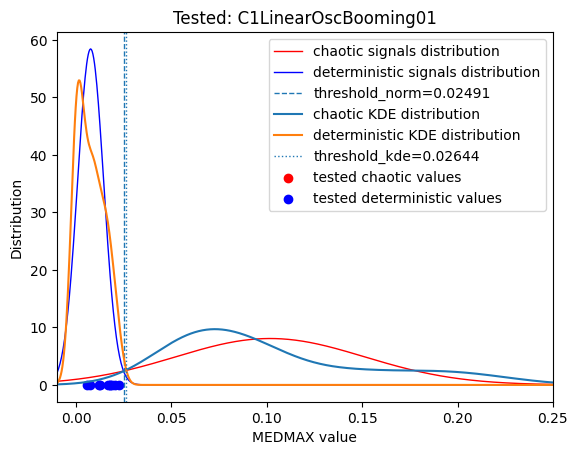

Threshold: 0.024913949271665823
Ground truth : [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Model answer: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[[10]]
Accuracy: 100.0
Train types: ['C0ModelHalvorsenA513', 'C0ModelLorenzA51', 'C0ModelRoslerA52', 'C0ModelRucklideA515', 'C0ModelUedaA45', 'C1LinearOscBooming01', 'C1LinearOscFading02', 'C1LinearOscillator01', 'C1LinearOscillator02']
Tested type: C1LinearOscFading01


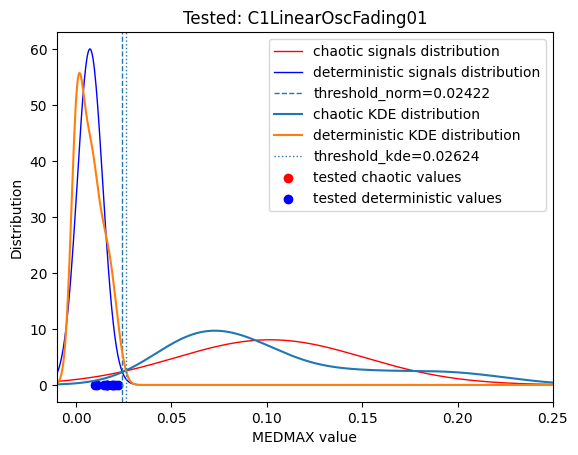

Threshold: 0.024217739163236638
Ground truth : [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Model answer: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[[10]]
Accuracy: 100.0
Train types: ['C0ModelHalvorsenA513', 'C0ModelLorenzA51', 'C0ModelRoslerA52', 'C0ModelRucklideA515', 'C0ModelUedaA45', 'C1LinearOscBooming01', 'C1LinearOscFading01', 'C1LinearOscillator01', 'C1LinearOscillator02']
Tested type: C1LinearOscFading02


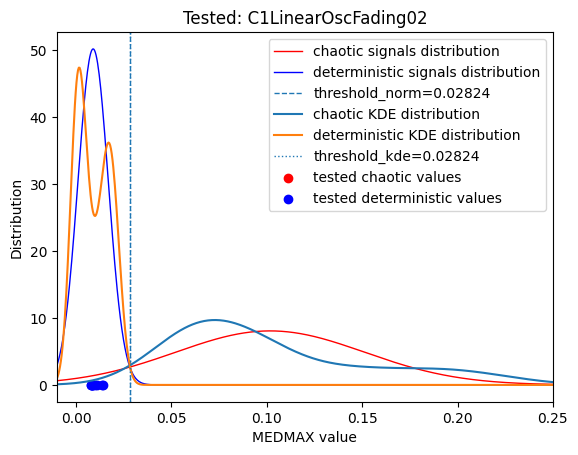

Threshold: 0.028239299168661892
Ground truth : [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Model answer: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[[10]]
Accuracy: 100.0
Train types: ['C0ModelHalvorsenA513', 'C0ModelLorenzA51', 'C0ModelRoslerA52', 'C0ModelRucklideA515', 'C0ModelUedaA45', 'C1LinearOscBooming01', 'C1LinearOscFading01', 'C1LinearOscFading02', 'C1LinearOscillator02']
Tested type: C1LinearOscillator01


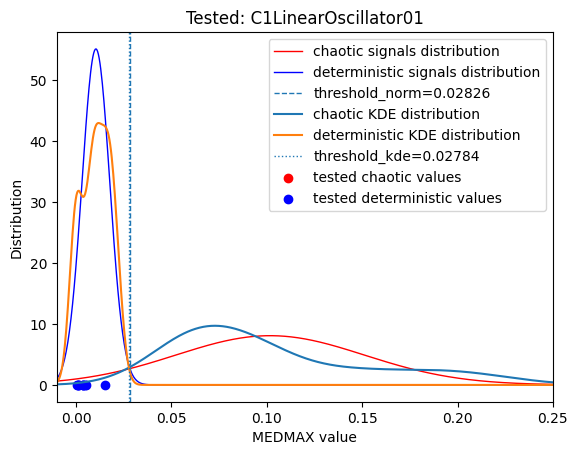

Threshold: 0.028255699654635584
Ground truth : [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Model answer: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[[10]]
Accuracy: 100.0
Train types: ['C0ModelHalvorsenA513', 'C0ModelLorenzA51', 'C0ModelRoslerA52', 'C0ModelRucklideA515', 'C0ModelUedaA45', 'C1LinearOscBooming01', 'C1LinearOscFading01', 'C1LinearOscFading02', 'C1LinearOscillator01']
Tested type: C1LinearOscillator02


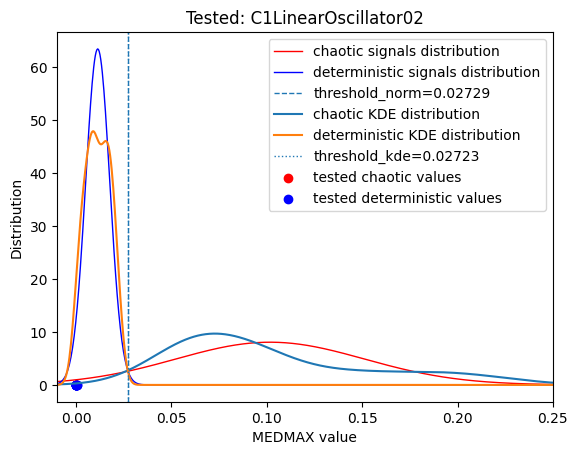

Threshold: 0.027293423148551356
Ground truth : [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Model answer: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[[10]]
Accuracy: 100.0
Accuracies: [100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0]
Mean accuracy: 100.0
C0ModelHalvorsenA513&100.0&0.02674\\
C0ModelLorenzA51&100.0&0.02789\\
C0ModelRoslerA52&100.0&0.02792\\
C0ModelRucklideA515&100.0&0.02708\\
C0ModelUedaA45&100.0&0.02717\\
C1LinearOscBooming01&100.0&0.02491\\
C1LinearOscFading01&100.0&0.02422\\
C1LinearOscFading02&100.0&0.02824\\
C1LinearOscillator01&100.0&0.02826\\
C1LinearOscillator02&100.0&0.02729\\


In [ ]:
#del(max)
accuracies = []
thresholds = []
for f in files:
    print('='*100)

    train_files = files.copy()
    train_files.remove(f)
    print("Train types:",train_files)
    print("Tested type:",f)
    train_c0,train_c1,test_c0,test_c1 = train_test_split(train_files)
    t = find_threshold(train_c0,train_c1)
    show_plot(train_c0,train_c1)

    plt.scatter(test_c0,np.zeros_like(test_c0),color='red',label="tested chaotic values")
    plt.scatter(test_c1,np.zeros_like(test_c1),color='blue',label="tested deterministic values")

    plt.xlim(-0.01,0.25)
    plt.legend(loc="upper right")
    plt.title(f'Tested: {f}')
    plt.show()
    print("Threshold:",max(t))
    a = calc_results(test_c0,test_c1,max(t))
    print("Accuracy:",a*100)
    accuracies.append(a*100)
    thresholds.append(max(t))

print("Accuracies:",accuracies)
print("Mean accuracy:",sum(accuracies)/len(accuracies))
for i,f in enumerate(files):
    print(f,accuracies[i],f"{thresholds[i]:.5f}",sep='&',end="\\\\\n")

<span style="color:blue">Comment: All results are perfect!</span>

## 4.3.2 Cross-validation using pairs of signals
Every pair of two signals (C0 and C1) is used to calculate the threshold and then the threshold is tested on all other types


[('C0ModelHalvorsenA513', 'C1LinearOscBooming01'), ('C0ModelHalvorsenA513', 'C1LinearOscFading01'), ('C0ModelHalvorsenA513', 'C1LinearOscFading02'), ('C0ModelHalvorsenA513', 'C1LinearOscillator01'), ('C0ModelHalvorsenA513', 'C1LinearOscillator02'), ('C0ModelLorenzA51', 'C1LinearOscBooming01'), ('C0ModelLorenzA51', 'C1LinearOscFading01'), ('C0ModelLorenzA51', 'C1LinearOscFading02'), ('C0ModelLorenzA51', 'C1LinearOscillator01'), ('C0ModelLorenzA51', 'C1LinearOscillator02'), ('C0ModelRoslerA52', 'C1LinearOscBooming01'), ('C0ModelRoslerA52', 'C1LinearOscFading01'), ('C0ModelRoslerA52', 'C1LinearOscFading02'), ('C0ModelRoslerA52', 'C1LinearOscillator01'), ('C0ModelRoslerA52', 'C1LinearOscillator02'), ('C0ModelRucklideA515', 'C1LinearOscBooming01'), ('C0ModelRucklideA515', 'C1LinearOscFading01'), ('C0ModelRucklideA515', 'C1LinearOscFading02'), ('C0ModelRucklideA515', 'C1LinearOscillator01'), ('C0ModelRucklideA515', 'C1LinearOscillator02'), ('C0ModelUedaA45', 'C1LinearOscBooming01'), ('C0Mode

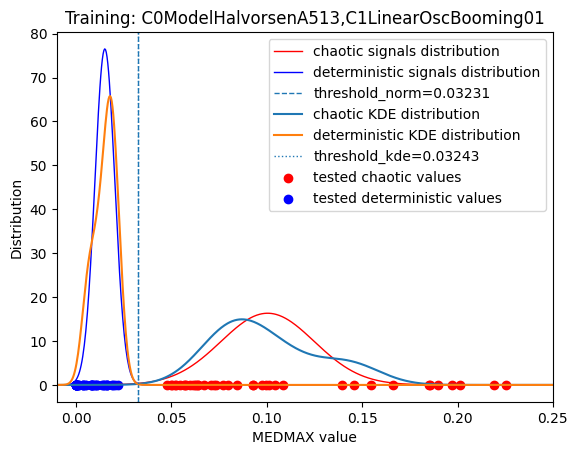

Threshold 0.03231144770701197
Ground truth : [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Model answer: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[[40  0]
 [ 0 40]]
Accuracy: 100.0
Train types: C0ModelHalvorsenA513 C1LinearOscFading01
Tested types: ['C0ModelLorenzA51', 'C0ModelRoslerA52', 'C0ModelRucklideA515', 'C0ModelUedaA45', 'C1LinearOscBooming01', 'C1LinearOscFading02', 'C1LinearOscillator01', 'C1LinearOscillator02']


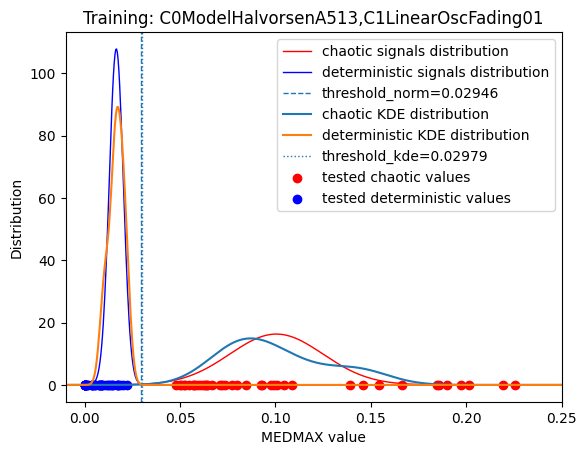

Threshold 0.02946133284075425
Ground truth : [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Model answer: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[[40  0]
 [ 0 40]]
Accuracy: 100.0
Train types: C0ModelHalvorsenA513 C1LinearOscFading02
Tested types: ['C0ModelLorenzA51', 'C0ModelRoslerA52', 'C0ModelRucklideA515', 'C0ModelUedaA45', 'C1LinearOscBooming01', 'C1LinearOscFading01', 'C1LinearOscillator01', 'C1LinearOscillator02']


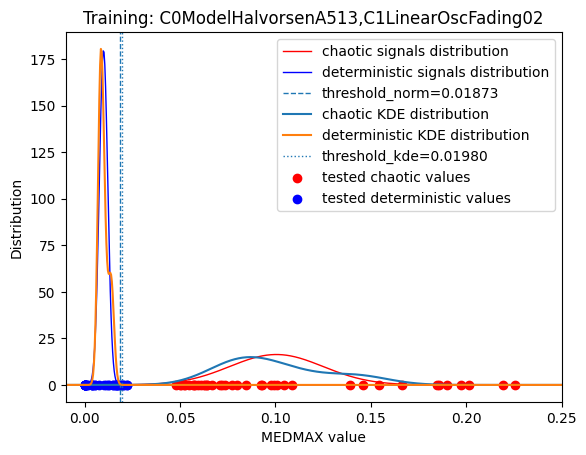

Threshold 0.0187299849788252
Ground truth : [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Model answer: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[[34  6]
 [ 0 40]]
Accuracy: 92.5
Train types: C0ModelHalvorsenA513 C1LinearOscillator01
Tested types: ['C0ModelLorenzA51', 'C0ModelRoslerA52', 'C0ModelRucklideA515', 'C0ModelUedaA45', 'C1LinearOscBooming01', 'C1LinearOscFading01', 'C1LinearOscFading02', 'C1LinearOscillator02']


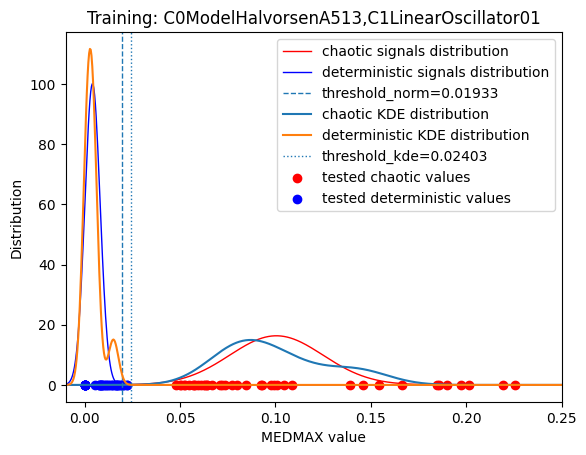

Threshold 0.019328738804924618
Ground truth : [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Model answer: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[[36  4]
 [ 0 40]]
Accuracy: 95.0
Train types: C0ModelHalvorsenA513 C1LinearOscillator02
Tested types: ['C0ModelLorenzA51', 'C0ModelRoslerA52', 'C0ModelRucklideA515', 'C0ModelUedaA45', 'C1LinearOscBooming01', 'C1LinearOscFading01', 'C1LinearOscFading02', 'C1LinearOscillator01']


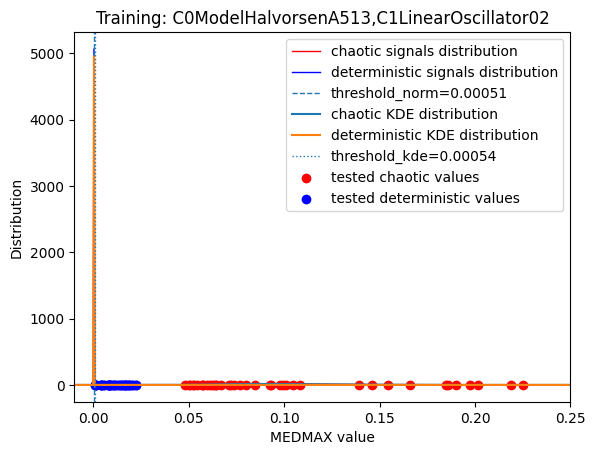

Threshold 0.0005110383662651767
Ground truth : [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Model answer: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
[[ 0 40]
 [ 0 40]]
Accuracy: 50.0
Train types: C0ModelLorenzA51 C1LinearOscBooming01
Tested types: ['C0ModelHalvorsenA513', 'C0ModelRoslerA52', 'C0ModelRucklideA515', 'C0ModelUedaA45', 'C1LinearOscFading01', 'C1LinearOscFading02', 'C1LinearOscillator01', 'C1LinearOscillator02']


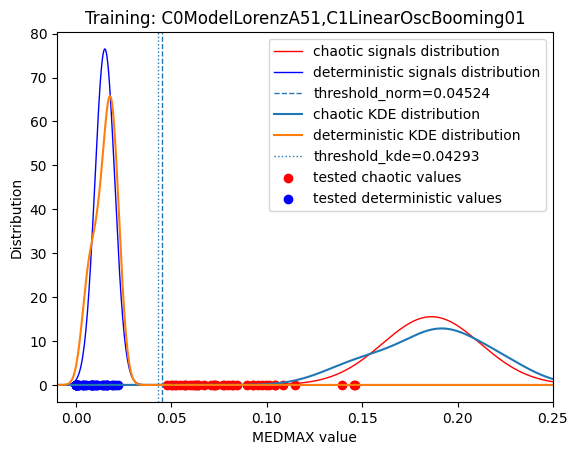

Threshold 0.04524253273877185
Ground truth : [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Model answer: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[[40  0]
 [ 0 40]]
Accuracy: 100.0
Train types: C0ModelLorenzA51 C1LinearOscFading01
Tested types: ['C0ModelHalvorsenA513', 'C0ModelRoslerA52', 'C0ModelRucklideA515', 'C0ModelUedaA45', 'C1LinearOscBooming01', 'C1LinearOscFading02', 'C1LinearOscillator01', 'C1LinearOscillator02']


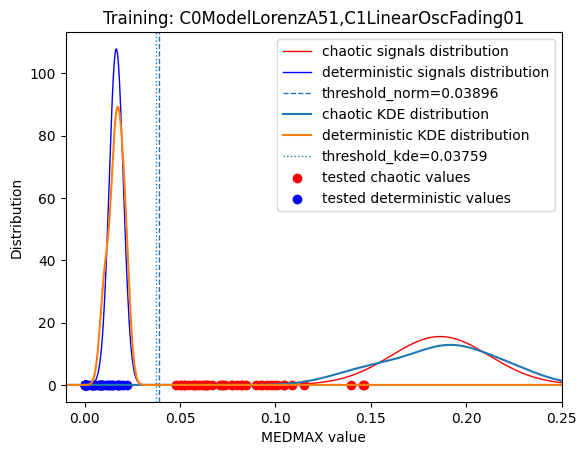

Threshold 0.03896483189647918
Ground truth : [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Model answer: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[[40  0]
 [ 0 40]]
Accuracy: 100.0
Train types: C0ModelLorenzA51 C1LinearOscFading02
Tested types: ['C0ModelHalvorsenA513', 'C0ModelRoslerA52', 'C0ModelRucklideA515', 'C0ModelUedaA45', 'C1LinearOscBooming01', 'C1LinearOscFading01', 'C1LinearOscillator01', 'C1LinearOscillator02']


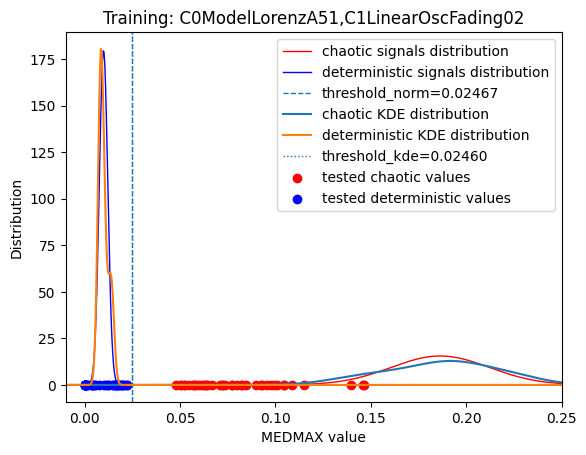

Threshold 0.02466567007698877
Ground truth : [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Model answer: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[[40  0]
 [ 0 40]]
Accuracy: 100.0
Train types: C0ModelLorenzA51 C1LinearOscillator01
Tested types: ['C0ModelHalvorsenA513', 'C0ModelRoslerA52', 'C0ModelRucklideA515', 'C0ModelUedaA45', 'C1LinearOscBooming01', 'C1LinearOscFading01', 'C1LinearOscFading02', 'C1LinearOscillator02']


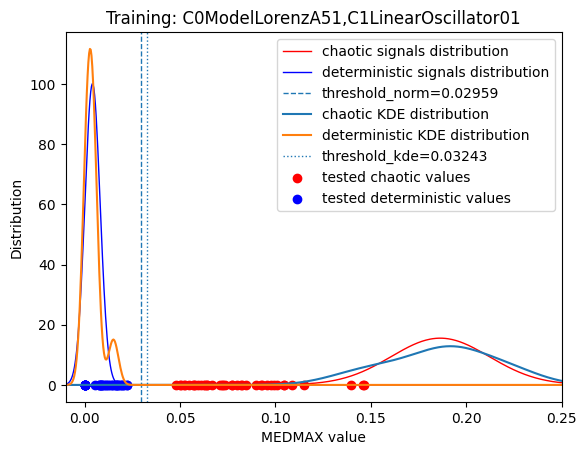

Threshold 0.029587765358498632
Ground truth : [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Model answer: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[[40  0]
 [ 0 40]]
Accuracy: 100.0
Train types: C0ModelLorenzA51 C1LinearOscillator02
Tested types: ['C0ModelHalvorsenA513', 'C0ModelRoslerA52', 'C0ModelRucklideA515', 'C0ModelUedaA45', 'C1LinearOscBooming01', 'C1LinearOscFading01', 'C1LinearOscFading02', 'C1LinearOscillator01']


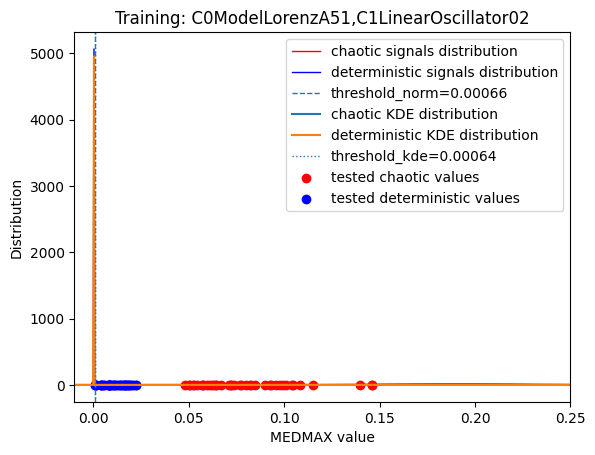

Threshold 0.0006579975060591028
Ground truth : [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Model answer: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
[[ 0 40]
 [ 0 40]]
Accuracy: 50.0
Train types: C0ModelRoslerA52 C1LinearOscBooming01
Tested types: ['C0ModelHalvorsenA513', 'C0ModelLorenzA51', 'C0ModelRucklideA515', 'C0ModelUedaA45', 'C1LinearOscFading01', 'C1LinearOscFading02', 'C1LinearOscillator01', 'C1LinearOscillator02']


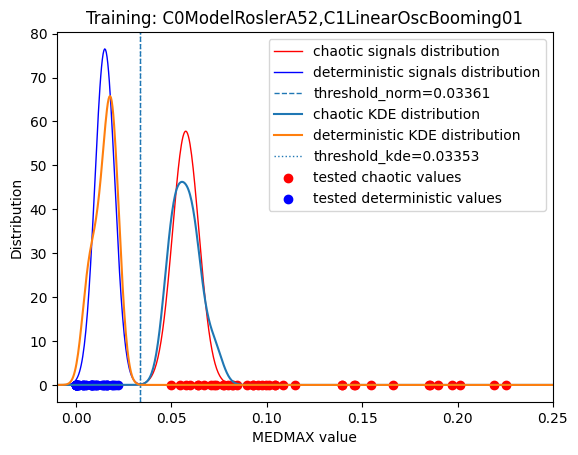

Threshold 0.03361091389825311
Ground truth : [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Model answer: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[[40  0]
 [ 0 40]]
Accuracy: 100.0
Train types: C0ModelRoslerA52 C1LinearOscFading01
Tested types: ['C0ModelHalvorsenA513', 'C0ModelLorenzA51', 'C0ModelRucklideA515', 'C0ModelUedaA45', 'C1LinearOscBooming01', 'C1LinearOscFading02', 'C1LinearOscillator01', 'C1LinearOscillator02']


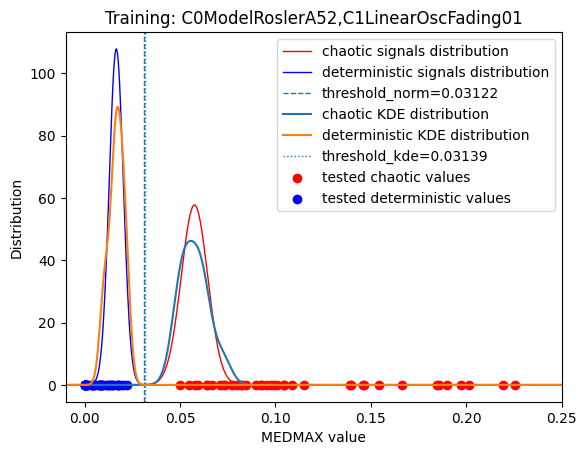

Threshold 0.03122272762049275
Ground truth : [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Model answer: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[[40  0]
 [ 0 40]]
Accuracy: 100.0
Train types: C0ModelRoslerA52 C1LinearOscFading02
Tested types: ['C0ModelHalvorsenA513', 'C0ModelLorenzA51', 'C0ModelRucklideA515', 'C0ModelUedaA45', 'C1LinearOscBooming01', 'C1LinearOscFading01', 'C1LinearOscillator01', 'C1LinearOscillator02']


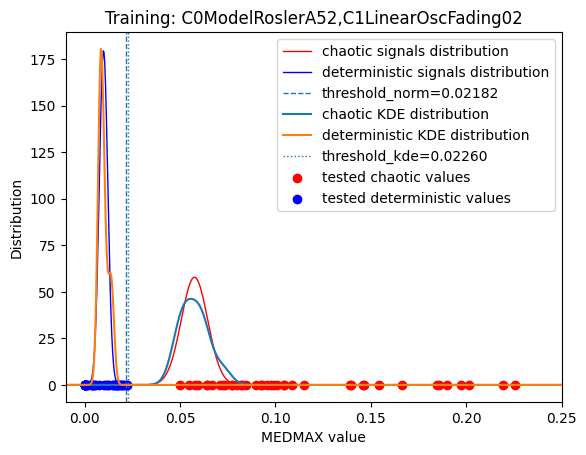

Threshold 0.021816648566643726
Ground truth : [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Model answer: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[[38  2]
 [ 0 40]]
Accuracy: 97.5
Train types: C0ModelRoslerA52 C1LinearOscillator01
Tested types: ['C0ModelHalvorsenA513', 'C0ModelLorenzA51', 'C0ModelRucklideA515', 'C0ModelUedaA45', 'C1LinearOscBooming01', 'C1LinearOscFading01', 'C1LinearOscFading02', 'C1LinearOscillator02']


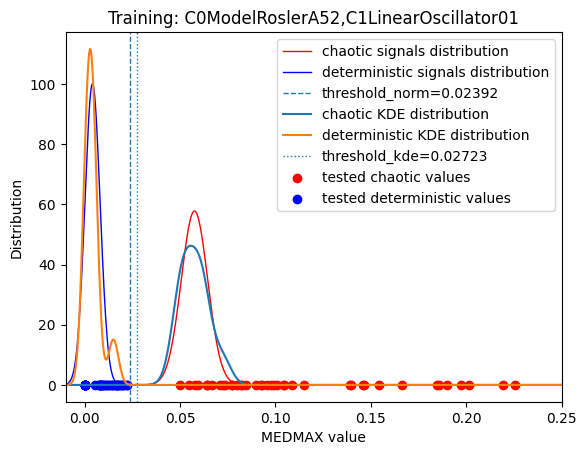

Threshold 0.0239238322751364
Ground truth : [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Model answer: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[[40  0]
 [ 0 40]]
Accuracy: 100.0
Train types: C0ModelRoslerA52 C1LinearOscillator02
Tested types: ['C0ModelHalvorsenA513', 'C0ModelLorenzA51', 'C0ModelRucklideA515', 'C0ModelUedaA45', 'C1LinearOscBooming01', 'C1LinearOscFading01', 'C1LinearOscFading02', 'C1LinearOscillator01']


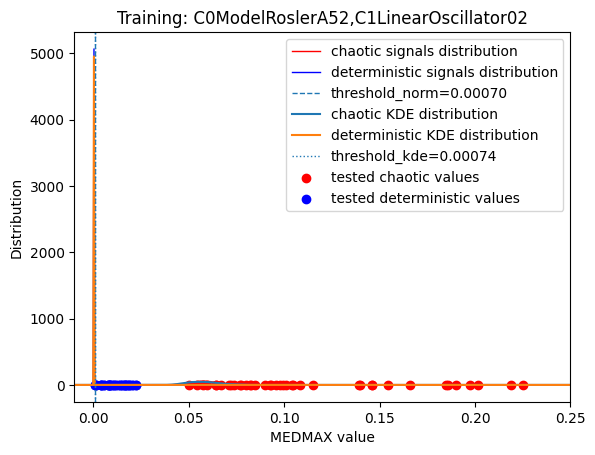

Threshold 0.0007003000888093022
Ground truth : [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Model answer: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
[[ 0 40]
 [ 0 40]]
Accuracy: 50.0
Train types: C0ModelRucklideA515 C1LinearOscBooming01
Tested types: ['C0ModelHalvorsenA513', 'C0ModelLorenzA51', 'C0ModelRoslerA52', 'C0ModelUedaA45', 'C1LinearOscFading01', 'C1LinearOscFading02', 'C1LinearOscillator01', 'C1LinearOscillator02']


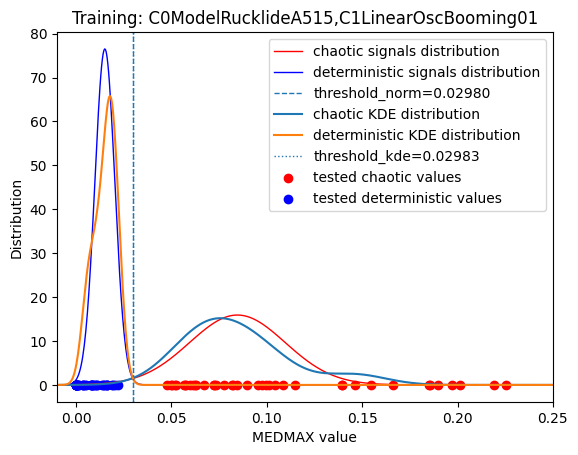

Threshold 0.029799727551251532
Ground truth : [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Model answer: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[[40  0]
 [ 0 40]]
Accuracy: 100.0
Train types: C0ModelRucklideA515 C1LinearOscFading01
Tested types: ['C0ModelHalvorsenA513', 'C0ModelLorenzA51', 'C0ModelRoslerA52', 'C0ModelUedaA45', 'C1LinearOscBooming01', 'C1LinearOscFading02', 'C1LinearOscillator01', 'C1LinearOscillator02']


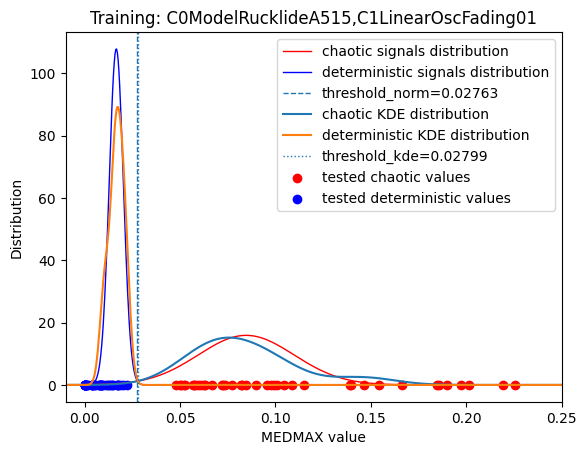

Threshold 0.027627849217393266
Ground truth : [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Model answer: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[[40  0]
 [ 0 40]]
Accuracy: 100.0
Train types: C0ModelRucklideA515 C1LinearOscFading02
Tested types: ['C0ModelHalvorsenA513', 'C0ModelLorenzA51', 'C0ModelRoslerA52', 'C0ModelUedaA45', 'C1LinearOscBooming01', 'C1LinearOscFading01', 'C1LinearOscillator01', 'C1LinearOscillator02']


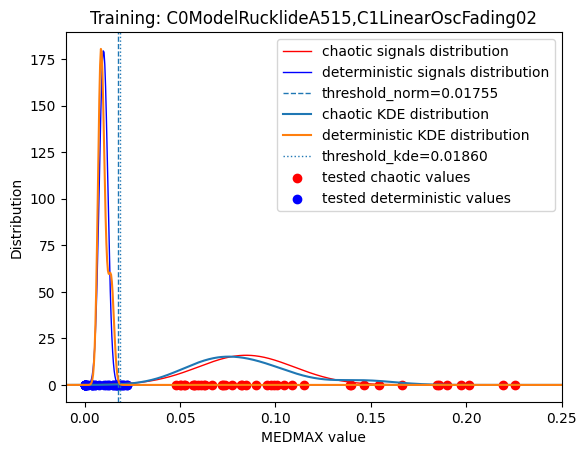

Threshold 0.017547692512377998
Ground truth : [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Model answer: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[[31  9]
 [ 0 40]]
Accuracy: 88.75
Train types: C0ModelRucklideA515 C1LinearOscillator01
Tested types: ['C0ModelHalvorsenA513', 'C0ModelLorenzA51', 'C0ModelRoslerA52', 'C0ModelUedaA45', 'C1LinearOscBooming01', 'C1LinearOscFading01', 'C1LinearOscFading02', 'C1LinearOscillator02']


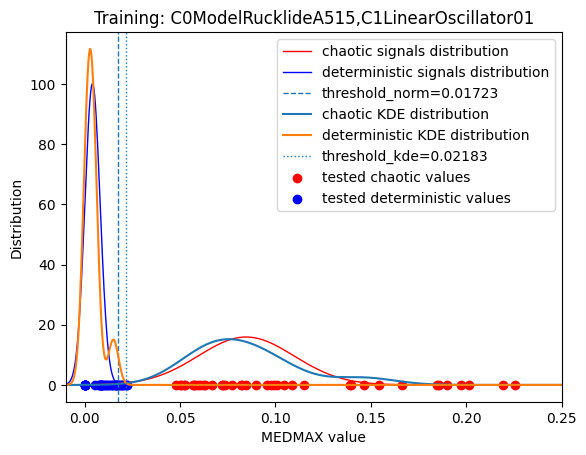

Threshold 0.017234631874110555
Ground truth : [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Model answer: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[[31  9]
 [ 0 40]]
Accuracy: 88.75
Train types: C0ModelRucklideA515 C1LinearOscillator02
Tested types: ['C0ModelHalvorsenA513', 'C0ModelLorenzA51', 'C0ModelRoslerA52', 'C0ModelUedaA45', 'C1LinearOscBooming01', 'C1LinearOscFading01', 'C1LinearOscFading02', 'C1LinearOscillator01']


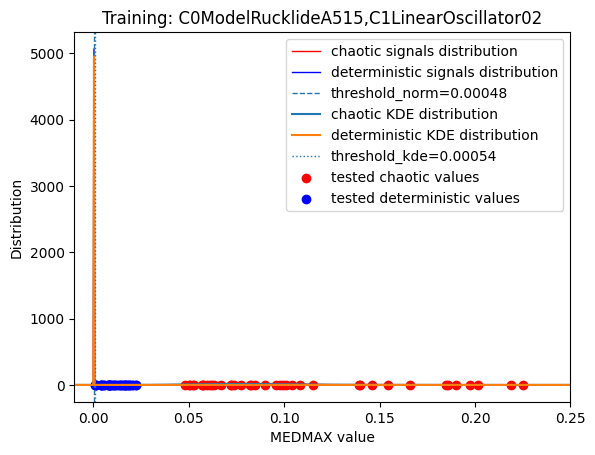

Threshold 0.0004817685794607537
Ground truth : [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Model answer: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
[[ 0 40]
 [ 0 40]]
Accuracy: 50.0
Train types: C0ModelUedaA45 C1LinearOscBooming01
Tested types: ['C0ModelHalvorsenA513', 'C0ModelLorenzA51', 'C0ModelRoslerA52', 'C0ModelRucklideA515', 'C1LinearOscFading01', 'C1LinearOscFading02', 'C1LinearOscillator01', 'C1LinearOscillator02']


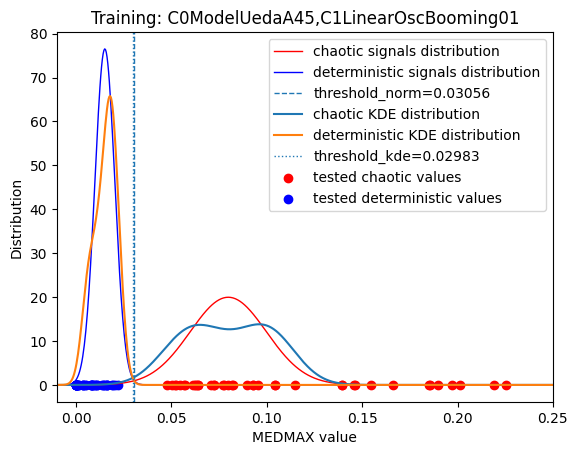

Threshold 0.030563640573241083
Ground truth : [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Model answer: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[[40  0]
 [ 0 40]]
Accuracy: 100.0
Train types: C0ModelUedaA45 C1LinearOscFading01
Tested types: ['C0ModelHalvorsenA513', 'C0ModelLorenzA51', 'C0ModelRoslerA52', 'C0ModelRucklideA515', 'C1LinearOscBooming01', 'C1LinearOscFading02', 'C1LinearOscillator01', 'C1LinearOscillator02']


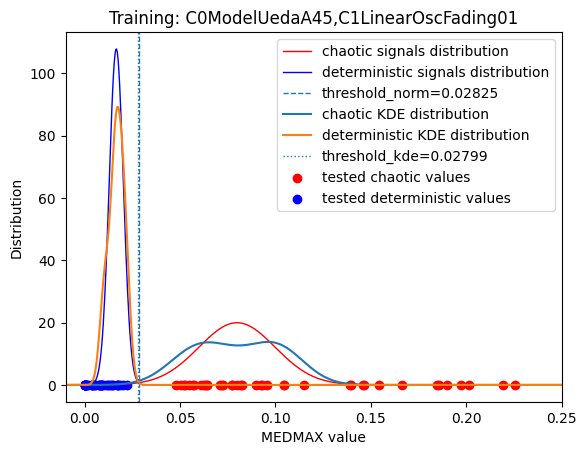

Threshold 0.0282531976050792
Ground truth : [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Model answer: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[[40  0]
 [ 0 40]]
Accuracy: 100.0
Train types: C0ModelUedaA45 C1LinearOscFading02
Tested types: ['C0ModelHalvorsenA513', 'C0ModelLorenzA51', 'C0ModelRoslerA52', 'C0ModelRucklideA515', 'C1LinearOscBooming01', 'C1LinearOscFading01', 'C1LinearOscillator01', 'C1LinearOscillator02']


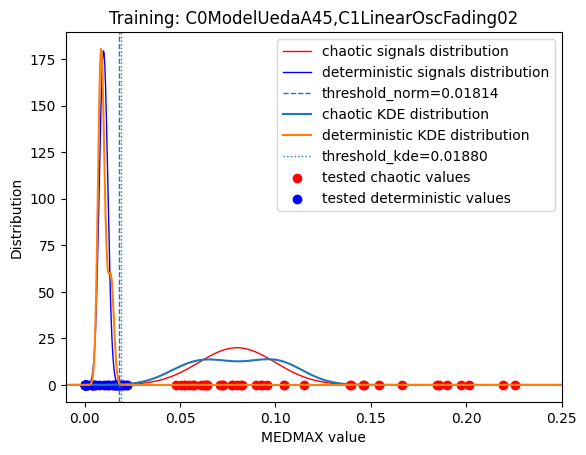

Threshold 0.018140562952681554
Ground truth : [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Model answer: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[[33  7]
 [ 0 40]]
Accuracy: 91.25
Train types: C0ModelUedaA45 C1LinearOscillator01
Tested types: ['C0ModelHalvorsenA513', 'C0ModelLorenzA51', 'C0ModelRoslerA52', 'C0ModelRucklideA515', 'C1LinearOscBooming01', 'C1LinearOscFading01', 'C1LinearOscFading02', 'C1LinearOscillator02']


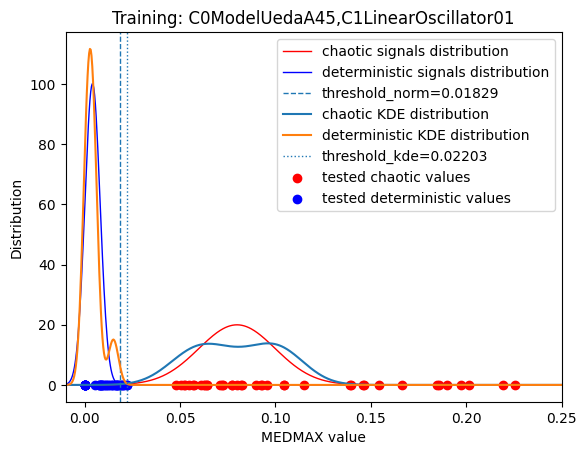

Threshold 0.018285705340501026
Ground truth : [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Model answer: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[[33  7]
 [ 0 40]]
Accuracy: 91.25
Train types: C0ModelUedaA45 C1LinearOscillator02
Tested types: ['C0ModelHalvorsenA513', 'C0ModelLorenzA51', 'C0ModelRoslerA52', 'C0ModelRucklideA515', 'C1LinearOscBooming01', 'C1LinearOscFading01', 'C1LinearOscFading02', 'C1LinearOscillator01']


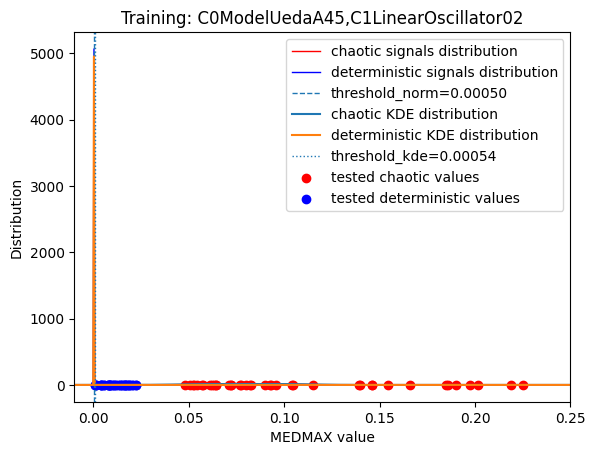

Threshold 0.0005039323200543579
Ground truth : [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Model answer: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
[[ 0 40]
 [ 0 40]]
Accuracy: 50.0
Accuracies: [100.0, 100.0, 92.5, 95.0, 50.0, 100.0, 100.0, 100.0, 100.0, 50.0, 100.0, 100.0, 97.5, 100.0, 50.0, 100.0, 100.0, 88.75, 88.75, 50.0, 100.0, 100.0, 91.25, 91.25, 50.0]
Mean accuracy: 87.8
C0ModelHalvorsenA513&C1LinearOscBooming01&100.0&0.032\\
C0ModelHalvorsenA513&C1LinearOscFading01&100.0&0.029\\
C0ModelHalvorsenA513&C1LinearOscFading02&92.5&0.019\\
C0ModelHalvorsenA513&C1LinearOscillator01&95.0&0.019\\
C0M

In [ ]:

# Create pairs of all signals
c0_files = [f for f in files if f.startswith('C0')]
c1_files = [f for f in files if f.startswith('C1')]
pairs = [(p1,p2) for p1 in c0_files for p2 in c1_files]
print(pairs)

accuracies = []
thresholds = []
for (f0,f1) in pairs:
    print("="*100)
    print("Train types:",f0,f1)
    test_files = files.copy()
    test_files.remove(f0)
    test_files.remove(f1)
    print("Tested types:",test_files)
    train_files = (f0,f1)
    train_c0,train_c1,test_c0,test_c1 = train_test_split(train_files)
    t = find_threshold(train_c0,train_c1)
    show_plot(train_c0,train_c1)
    plt.title(f"Training: {f0},{f1}")
    plt.scatter(test_c0,np.zeros_like(test_c0),color='red',label="tested chaotic values")
    plt.scatter(test_c1,np.zeros_like(test_c1),color='blue',label="tested deterministic values")
    plt.xlim(-0.01,0.25)
    plt.legend(loc="upper right")
    plt.show()
    print("Threshold",max(t))
    a = calc_results(test_c0,test_c1,max(t))
    print("Accuracy:",a*100)
    accuracies.append(a*100)
    thresholds.append(max(t))
print("Accuracies:",accuracies)
print("Mean accuracy:",sum(accuracies)/len(accuracies))
for i,(f0,f1) in enumerate(pairs):
    print(f0,f1,accuracies[i],f"{thresholds[i]:.3f}",sep='&',end="\\\\\n")


for a in accuracies:
    print(a)

<span style="color:blue">Comment: Results for pairs with 'C1LinearOscillator02' are poor because this signal was very easy to learn for the model and exhibits very low medmax values (see below). Because of that its normal distribution characterizes with very low standard deviation and the intersection point with any other distributionis always close to zero. Similar problems (but not so bad) for 'C1LinearOscFading02'.</span>

In [ ]:
print(medmax["C1LinearOscillator02"])
print("(mean,std)=",norm.fit(medmax["C1LinearOscillator02"]))

[0.00015819267694715527, 0.00014274029552082258, 0.00013572984004486704, 0.0002840469907347382, 0.00023762348974354198, 0.00023155499138884631, 0.0002461161155385998, 0.00017415225815639593, 0.00022542641735626072, 0.0003019085759753415]
(mean,std)= (0.00021374916514065693, 5.5288866509608434e-05)


In [ ]:
print(medmax["C1LinearOscFading02"])
print("(mean,std)=",norm.fit(medmax["C1LinearOscFading02"]))

[0.013716701377671349, 0.008031355039545777, 0.008561097506898421, 0.00853687560960025, 0.008844483588271456, 0.009790652755386646, 0.014091022786519105, 0.011053499879113011, 0.008267837636103734, 0.0076972581461689175]
(mean,std)= (0.009859078432527868, 0.0022187923962766203)


# Checking H3 with Machine Learning
# 4.4 Using K-Nearest Neighbors algorithm to find the threshold

In [ ]:
# helper function that produces list of samples with label=1 for chaotic and label=0 for deterministic signals
def convert_to_samples_labels(list_c0,list_c1):
    samples = np.array(list_c0 + list_c1)
    labels = list([1]*len(list_c0))+list([0]*len(list_c1))
    samples = samples.reshape(-1, 1)
    return samples,labels


## 4.4.1 Leave-one-type-out

In [ ]:
import sklearn
from sklearn.neighbors import KNeighborsClassifier

accuracies = []

for f in files:
    print('='*100)

    train_files = files.copy()
    train_files.remove(f)
    print("Train types:",train_files)
    print("Tested type:",f)
    train_c0,train_c1,test_c0,test_c1 = train_test_split(train_files)

    model = KNeighborsClassifier()
    train_samples, train_labels = convert_to_samples_labels(train_c0,train_c1)
    model.fit(train_samples, train_labels)

    test_samples, test_labels = convert_to_samples_labels(test_c0,test_c1)
    pred_labels = model.predict(test_samples)
    #print("predicted",pred_labels)

    # print(confusion_matrix(test_labels, pred_labels))
    # print(classification_report(test_labels, pred_labels))
    #print(f"Accuracy: {accuracy_score(test_labels, pred_labels):.2f}")
    a = accuracy_score(test_labels, pred_labels)
    print("Accuracy:",a*100)
    accuracies.append(a*100)

print("Accuracies:",accuracies)
print("Mean accuracy:",sum(accuracies)/len(accuracies))
for i,f in enumerate(files):
    print(f,accuracies[i],sep='&',end="\\\\\n")

Train types: ['C0ModelLorenzA51', 'C0ModelRoslerA52', 'C0ModelRucklideA515', 'C0ModelUedaA45', 'C1LinearOscBooming01', 'C1LinearOscFading01', 'C1LinearOscFading02', 'C1LinearOscillator01', 'C1LinearOscillator02']
Tested type: C0ModelHalvorsenA513
Accuracy: 100.0
Train types: ['C0ModelHalvorsenA513', 'C0ModelRoslerA52', 'C0ModelRucklideA515', 'C0ModelUedaA45', 'C1LinearOscBooming01', 'C1LinearOscFading01', 'C1LinearOscFading02', 'C1LinearOscillator01', 'C1LinearOscillator02']
Tested type: C0ModelLorenzA51
Accuracy: 100.0
Train types: ['C0ModelHalvorsenA513', 'C0ModelLorenzA51', 'C0ModelRucklideA515', 'C0ModelUedaA45', 'C1LinearOscBooming01', 'C1LinearOscFading01', 'C1LinearOscFading02', 'C1LinearOscillator01', 'C1LinearOscillator02']
Tested type: C0ModelRoslerA52
Accuracy: 100.0
Train types: ['C0ModelHalvorsenA513', 'C0ModelLorenzA51', 'C0ModelRoslerA52', 'C0ModelUedaA45', 'C1LinearOscBooming01', 'C1LinearOscFading01', 'C1LinearOscFading02', 'C1LinearOscillator01', 'C1LinearOscillator02

## 4.4.2 Classification using pairs of signals as the training set

In [ ]:
accuracies = []


for (f0,f1) in pairs:
    print("="*100)
    print("Train types:",f0,f1)
    test_files = files.copy()
    test_files.remove(f0)
    test_files.remove(f1)
    print("Tested types:",test_files)
    train_files = (f0,f1)
    train_c0,train_c1,test_c0,test_c1 = train_test_split(train_files)

    model = KNeighborsClassifier()
    train_samples, train_labels = convert_to_samples_labels(train_c0,train_c1)
    model.fit(train_samples, train_labels)

    test_samples, test_labels = convert_to_samples_labels(test_c0,test_c1)
    pred_labels = model.predict(test_samples)
    #print("predicted",pred_labels)

    print(confusion_matrix(test_labels, pred_labels))
    #print(classification_report(test_labels, pred_labels))
    #print(f"Accuracy: {accuracy_score(test_labels, pred_labels):.2f}")
    a = accuracy_score(test_labels, pred_labels)
    print("Accuracy:",a*100)
    accuracies.append(a*100)

print("Accuracies:",accuracies)
print("Mean accuracy:",sum(accuracies)/len(accuracies))

for i,(f0,f1) in enumerate(pairs):
    print(f0,f1,accuracies[i],sep='&',end="\\\\\n")

Train types: C0ModelHalvorsenA513 C1LinearOscBooming01
Tested types: ['C0ModelLorenzA51', 'C0ModelRoslerA52', 'C0ModelRucklideA515', 'C0ModelUedaA45', 'C1LinearOscFading01', 'C1LinearOscFading02', 'C1LinearOscillator01', 'C1LinearOscillator02']
[[40  0]
 [ 2 38]]
Accuracy: 97.5
Train types: C0ModelHalvorsenA513 C1LinearOscFading01
Tested types: ['C0ModelLorenzA51', 'C0ModelRoslerA52', 'C0ModelRucklideA515', 'C0ModelUedaA45', 'C1LinearOscBooming01', 'C1LinearOscFading02', 'C1LinearOscillator01', 'C1LinearOscillator02']
[[40  0]
 [ 3 37]]
Accuracy: 96.25
Train types: C0ModelHalvorsenA513 C1LinearOscFading02
Tested types: ['C0ModelLorenzA51', 'C0ModelRoslerA52', 'C0ModelRucklideA515', 'C0ModelUedaA45', 'C1LinearOscBooming01', 'C1LinearOscFading01', 'C1LinearOscillator01', 'C1LinearOscillator02']
[[40  0]
 [ 0 40]]
Accuracy: 100.0
Train types: C0ModelHalvorsenA513 C1LinearOscillator01
Tested types: ['C0ModelLorenzA51', 'C0ModelRoslerA52', 'C0ModelRucklideA515', 'C0ModelUedaA45', 'C1LinearO

# Final part: Lyapunov calculation
We use lyap_r() function from nolds that estimates the largest Lyapunov exponent (LLE) using the algorithm of Rosenstein et al. [lr_1].
We calculate LLE for all 100 signals.

In [ ]:
!pip install nolds

In [ ]:
import nolds
import warnings
warnings.filterwarnings('ignore')
print("type", "no", "LLE", sep="\t")
for file in files:
    for n in range(1,11):
        df = pd.read_csv(f'{file}/{file}-{n}.txt',header=None,usecols=[0])
        data = df[df.columns[0]].values.tolist()
        print(file, n, nolds.lyap_r(data), sep="\t")
warnings.filterwarnings('default')


type	no	LLE
C0ModelHalvorsenA513	1	0.025224703236630057
C0ModelHalvorsenA513	2	0.029039599169465857
C0ModelHalvorsenA513	3	0.02887916376716214
C0ModelHalvorsenA513	4	0.02438778178136151
C0ModelHalvorsenA513	5	0.02650573898975117
C0ModelHalvorsenA513	6	0.02029147352913403
C0ModelHalvorsenA513	7	0.0207585180612435
C0ModelHalvorsenA513	8	0.02681199652808053
C0ModelHalvorsenA513	9	0.018027249314731226
C0ModelHalvorsenA513	10	0.027974631822198875
C0ModelLorenzA51	1	0.08936799397145892
C0ModelLorenzA51	2	0.06765053061614362
C0ModelLorenzA51	3	0.07559744110681059
C0ModelLorenzA51	4	0.08494178684134232
C0ModelLorenzA51	5	0.08687394445103808
C0ModelLorenzA51	6	0.07938006067634525
C0ModelLorenzA51	7	0.06911068240502723
C0ModelLorenzA51	8	0.08128584381332972
C0ModelLorenzA51	9	0.07433389192236996
C0ModelLorenzA51	10	0.07446649554080535
C0ModelRoslerA52	1	0.017492575316052684
C0ModelRoslerA52	2	0.014991026331103385
C0ModelRoslerA52	3	0.018763230685004618
C0ModelRoslerA52	4	0.015561769891502266
C0M

<span style="color:blue">Comment: It does not work very good for our signals!</span>